# Проектная работа: Определение стоимости автомобилей

## Описание проекта
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.
Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

## План по выполнению проекта

1. [Предобработка данных](#prep)
2. [Анализ данных](#analisys)  
    2.1 [Корреляция данных](#analisys)  
    2.2 [Распределение по годам регистрации](#years)  
    2.3 [Анализ по группам](#group)  
3. [Построение моделей](#model)  
    3.1 [Target кодирование](#model)  
    3.2 [ОНЕ кодирование](#ohe)    
    3.3 [LinearRegression](#lr)  
    3.4 [Ridge](#ridge)  
    3.5 [LGBM](#lgbm)  
4. [Вывод](#concl)   

Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг. Поэкспериментируйте и сравните характеристики моделей: скорость работы, точность результата.
Загрузите и подготовьте данные.
Обучите разные модели. Для каждой попробуйте различные гиперпараметры.
Проанализируйте скорость работы и качество моделей.

Примечания:
Для оценки качества моделей применяйте метрику RMSE.
Значение метрики RMSE должно быть меньше 2500.
Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.
Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del:
del features_train 

## Описание данных
Данные находятся в файле /datasets/autos.csv. Скачать датасет.
Признаки
`DateCrawled` — дата скачивания анкеты из базы\
`VehicleType` — тип автомобильного кузова\
`RegistrationYear` — год регистрации автомобиля\
`Gearbox` — тип коробки передач\
`Power` — мощность (л. с.)\
`Model` — модель автомобиля\
`Kilometer` — пробег (км)\
`RegistrationMonth` — месяц регистрации автомобиля\
`FuelType` — тип топлива\
`Brand` — марка автомобиля\
`NotRepaired` — была машина в ремонте или нет\
`DateCreated` — дата создания анкеты\
`NumberOfPictures` — количество фотографий автомобиля\
`PostalCode` — почтовый индекс владельца анкеты (пользователя)\
`LastSeen` — дата последней активности пользователя\
Целевой признак\
`Price` — цена (евро)

### Предобработка данных  <a id='prep'></a>

В следующей ячейке будем хранить все импортированные библиотеки

In [1]:
import pandas as pd
import numpy as np
import time

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression,  Ridge, Lasso
import lightgbm

Загрузим данные

In [2]:
try:
    df =  pd.read_csv('C:/Users/79153/Desktop/ya_projects/sprint_14/autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [3]:
print(df.info())
print('---'*15)
print(df.describe())
print('---'*15)
print(df.head(10))
initial_len = len(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

#### Вывод:
1. В данных присутствуют пропуски
2. Названия колонок следует привести к общепринятому виду
3. Тип данных не всегда соответствует смысловому наполнению колонок
4. Колонка `NumberOfPictures` содержит исключительно нули
6. `RegistrationYear` содержит несуществующие даты постановки на учет, например 9999


Приведем колонки к общепринятому змеиному регистру

In [4]:
df.columns = ['date_drawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']
df.columns

Index(['date_drawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Рассмотрим подробнее колонку `postal_code`

In [5]:
print('Number of unique postal code: ', len(df['postal_code'].unique()))
print('Percent of uniqiue postal code: ', round(len(df['postal_code'].unique())/len(df['postal_code']), 4))

Number of unique postal code:  8143
Percent of uniqiue postal code:  0.023


Данная колонка дает представление о регионе продажи автомобиля и соответственно важна для исследования, так как цены на авто могут существенно различаться в различных регионах.

Рассмотрим уникальные значения в некоторых столбцах.

In [6]:
df['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'trabant', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'porsche', 'rover', 'land_rover', 'lada'], dtype=object)

In [7]:
df['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [8]:
df['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

В диалектах английского языка есть двоечтение -  gasoline (США) то же что и petrol (Великобритания), однако следует понимать что есть и газолин как газообразный бензин отдельный вид топлива, что конкретно подразумевалось в данной колонке неизвестно, чтобы не навредить исследованию менять ничего не будем.

Посмотрим подробнее данные по мощности

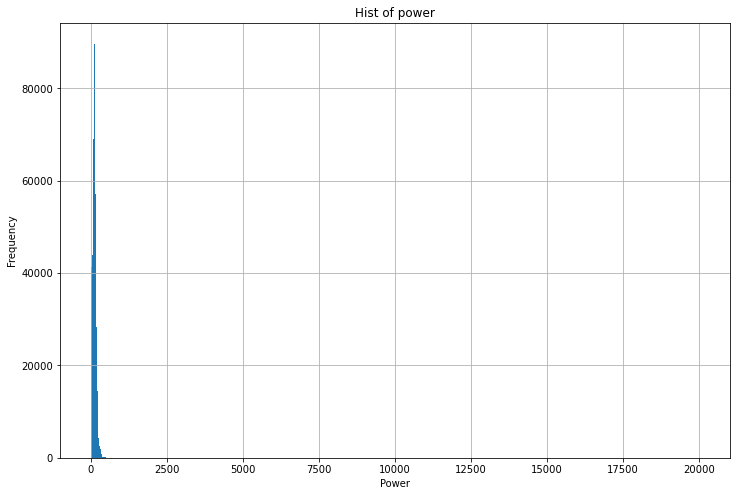

In [9]:
fig, ax = plt.subplots(figsize=[12,8])
df['power'].plot(kind='hist', bins=600)
ax.grid()
ax.set_title("Hist of power")
ax.set_xlabel("Power")
plt.show()

Определим доверительные интервалы

In [10]:
def intervals(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    diff = q3 - q1
    
    left_int = q1 - 1.5 * diff
    right_int = q3 + 1.5 * diff
    
    return left_int, right_int

In [11]:
power_int_l,power_int_r = intervals(df['power'])
print('Confidence interval for "power": ', power_int_l,power_int_r)

Confidence interval for "power":  -42.0 254.0


Обратим внимание что число автомобилей с 0 лс крайне велико, это явный выброс, поэтому ограничим нижнюю границу исходя из физического смысла  величины  - мощностью 20 лс обладал один из первых серийных автомобилей Ford Model T 

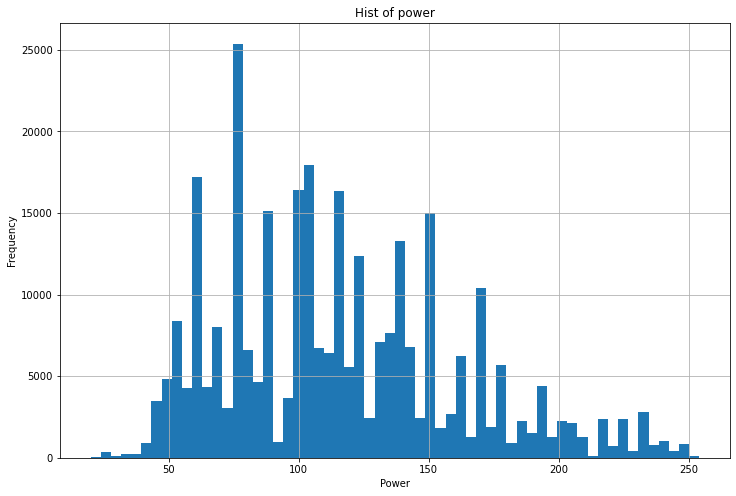

In [12]:
df = df[df['power']<=power_int_r]
df = df[20<=df['power']]

fig, ax = plt.subplots(figsize=[12,8])
df['power'].plot(kind='hist', bins=60)
ax.grid()
ax.set_title("Hist of power")
ax.set_xlabel("Power")
plt.show()

<font color="green">✔️ Комментарий ревьювера   
Согласен, мощность от 20 до 254 кажется правдоподобной</font>


Рассмотрим подробнее временные колонки

In [13]:
df['date_drawled'] = pd.to_datetime(df['date_drawled'],format='%Y-%m-%d %H:%M:%S') 
df['date_created'] = pd.to_datetime(df['date_created'],format='%Y-%m-%d %H:%M:%S') 
df['last_seen'] = pd.to_datetime(df['last_seen'],format='%Y-%m-%d %H:%M:%S') 

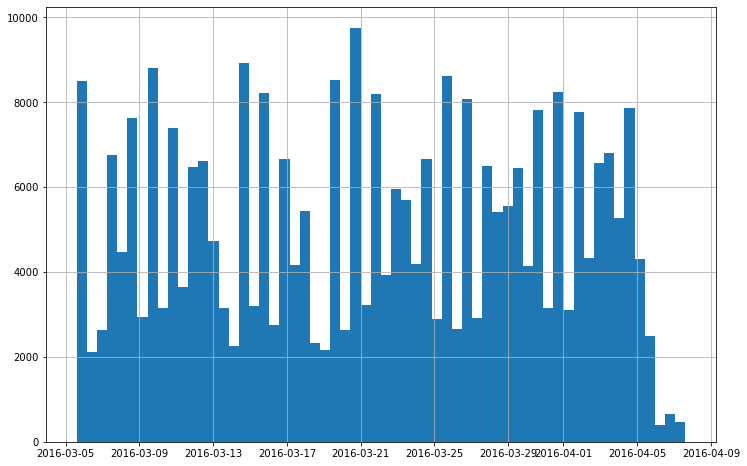

In [14]:
fig, ax = plt.subplots(figsize=[12,8])
df['date_drawled'].hist(bins=60)
plt.show()

Очевидно что дата регистрации автомобиля не может быть позже даты скачивания, но так же следует учесть что столбец `registration_year` содержит и заниженные даты до 1000, для исследования ограничимся началом 20го века, так как автомобилестроение вышло на серийное производство только в начале столетия, а все что было ранее единичный антиквариат.

In [15]:
df = df[df['registration_year']<=2016]
df = df[1900<=df['registration_year']]

Сами по себе временные столбцы не имеют смыла, но можно вычесть время от размещения анкеты, до последнего посещения, таким образом, определив быстрые и долгосрочные продажи, данный параметр может показать справедливость цены продавца.

In [16]:
df['sale_duration'] = (df['last_seen'] - df['date_created']).dt.days

Определим бесполезные столбцы для исследования:
1. `date_drawled`, `date_created` и `last_seen` - свою роль в исследовании они уже сыграли
2. `number_of_pictures`  - содержит исключительно нули
3. `registration_month` - учитывая разброс дат регистрации едвали месяц регистрации может сыграть роль

In [17]:
df.drop(['date_drawled','last_seen', 'date_created', 'registration_month', 'number_of_pictures'], inplace=True, axis=1)

Осмотрим пропуски в оставшихся столбцах

In [18]:
def null_percent(data):
    null_part = round(data.isna().sum()/len(data), 4)
    print('Percent of nulls: ', null_part)
    
print('vehicle_type')
null_percent(df['vehicle_type'])
print('---'*15)
print('gearbox')
null_percent(df['gearbox'])
print('---'*15)
print('not_repaired')
null_percent(df['not_repaired'])
print('---'*15)
print('model')
null_percent(df['model'])

vehicle_type
Percent of nulls:  0.0399
---------------------------------------------
gearbox
Percent of nulls:  0.0191
---------------------------------------------
not_repaired
Percent of nulls:  0.1501
---------------------------------------------
model
Percent of nulls:  0.0383


Можно заметить, пропуски в колонках до 5% можно спокойно удалить, но при этом стоит обратить внимание на параметр `not_repaired` - очевидно что часть владельцев не заполняя данную графу пытается скрыть повреждения автомобиля, хотя и утвеждать что это однозначно умысел нельзя. В данной колонке воспользуемся заполнением маркерным значением, для ликвидации пропусков.

In [19]:
df['not_repaired'].fillna('no_data', inplace=True)
df.dropna(inplace=True)

Рассмотрим подробнее распределение цены

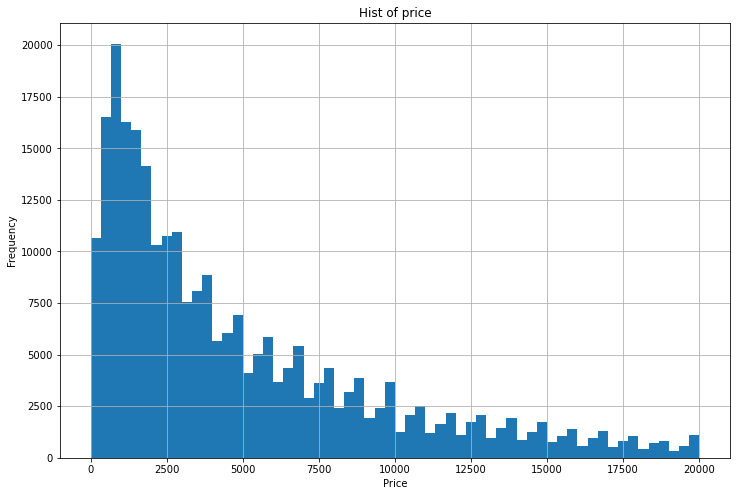

In [20]:
fig, ax = plt.subplots(figsize=[12,8])
df['price'].plot(kind='hist', bins=60)
ax.grid()
ax.set_title("Hist of price")
ax.set_xlabel("Price")
plt.show()

видим присутствие цены в 0 евро на гистограмме, попробуем понять каков процент таких объявлений.

In [21]:
intervals(df['price'])

(-7017.25, 15408.75)

In [22]:
print('Percent without price: ', round(len(df[df['price']==0])/len(df), 4))

Percent without price:  0.0156


Предположим что данные объявления состоят как из утаивших цену так и из обладателей неликвида, который невозможно сбыть. Эти данные можно удалить ввиду их небольшого количества. Ограничивать датафрейм по верхней границе доверительного интервала не будем, так как на гистограмме распределение близкое к нормальному со скосом. 

In [23]:
df = df[df['price']!=0] 

Проверим и удалим явные дубликаты

In [24]:
print('Number of duplicates before: ', df.duplicated().sum())
df.drop_duplicates(inplace=True)
print('Number of duplicates now: ', df.duplicated().sum())

Number of duplicates before:  8498
Number of duplicates now:  0


Осмотрим результат обработки данных

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249094 entries, 2 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              249094 non-null  int64 
 1   vehicle_type       249094 non-null  object
 2   registration_year  249094 non-null  int64 
 3   gearbox            249094 non-null  object
 4   power              249094 non-null  int64 
 5   model              249094 non-null  object
 6   kilometer          249094 non-null  int64 
 7   fuel_type          249094 non-null  object
 8   brand              249094 non-null  object
 9   not_repaired       249094 non-null  object
 10  postal_code        249094 non-null  int64 
 11  sale_duration      249094 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 24.7+ MB


In [26]:
df.reset_index(inplace=True, drop=True)
df.head()

price vehicle_type  registration_year gearbox  power    model  kilometer  \
0   9800          suv               2004    auto    163    grand     125000   
1   1500        small               2001  manual     75     golf     150000   
2   3600        small               2008  manual     69    fabia      90000   
3    650        sedan               1995  manual    102      3er     150000   
4   2200  convertible               2004  manual    109  2_reihe     150000   

  fuel_type       brand not_repaired  postal_code  sale_duration  
0  gasoline        jeep      no_data        90480             22  
1    petrol  volkswagen           no        91074              0  
2  gasoline       skoda           no        60437              6  
3    petrol         bmw          yes        33775              2  
4    petrol     peugeot           no        67112              4

In [27]:
print('Percent of initial data: ', round(len(df)/initial_len,4))

Percent of initial data:  0.7029


Процент от исходных данных небольшой, данные были собраны с пропусками и ошибками.

### Анализ данных <a id='analisys'></a>

Рассмотрим корреляцию данных

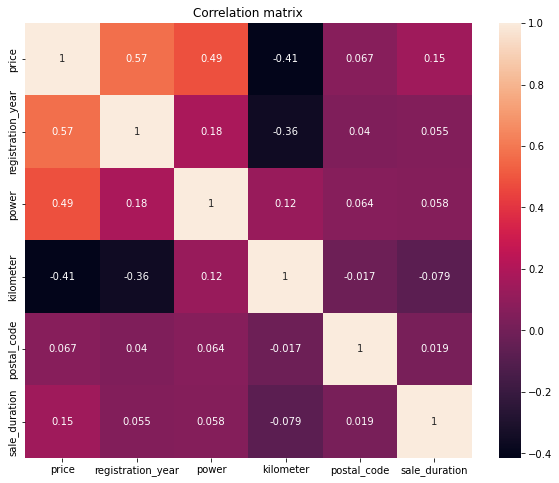

In [28]:
fig, axes = plt.subplots(1, 1, figsize=(10,8))
ax = sns.heatmap(df.corr(), annot=True)
ax.set_title('Correlation matrix')
plt.show()

#### Распределение  по годам выпуска. <a id='years'></a>

In [29]:
def dependence (data, time, first, second, third):
    for j in data[first].unique():

        fig = plt.figure(figsize=(16, 8))
        fig.suptitle(str(j),  fontsize=20)

        df_1 = data[data[first] == j]

        ax1 = fig.add_subplot()
    
        times = data[second].unique()
        
        for i in range(len(df[second].unique())):
            df_2 = df_1[df_1[second] == times[i]]
        
            ax1.scatter(df_2[time], df_2[third], s=10, label=times[i], alpha=0.75)

            plt.ylabel(third)
            plt.legend(loc='upper left')
            ax1.patch.set_facecolor('#F0FFFF')
            plt.grid()

        plt.show()

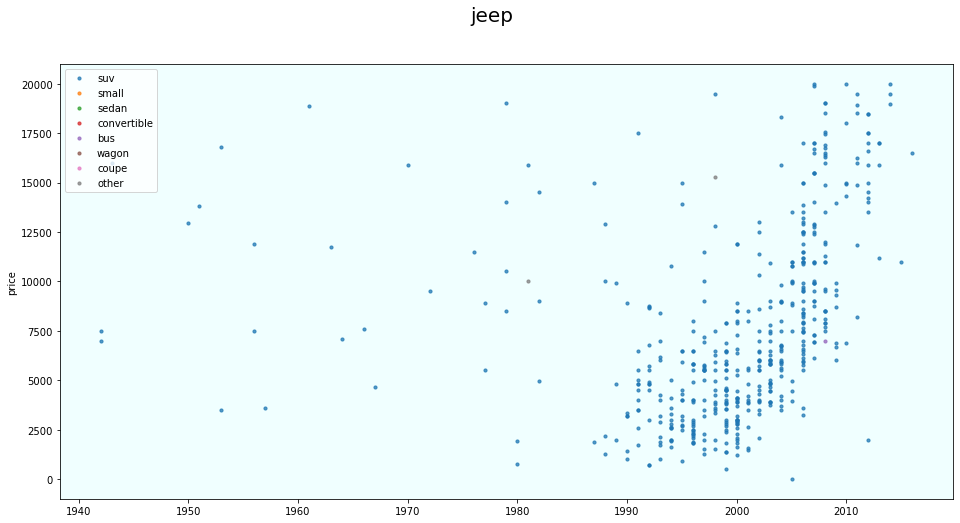

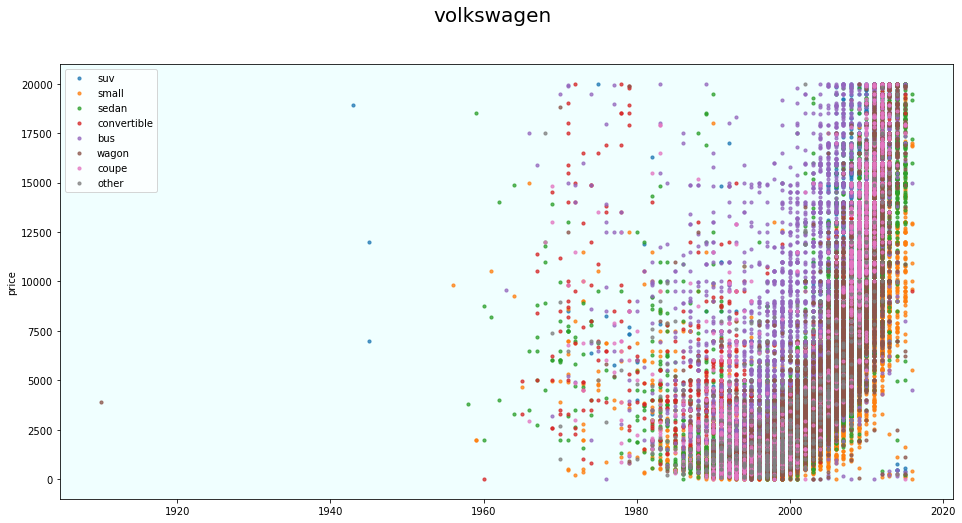

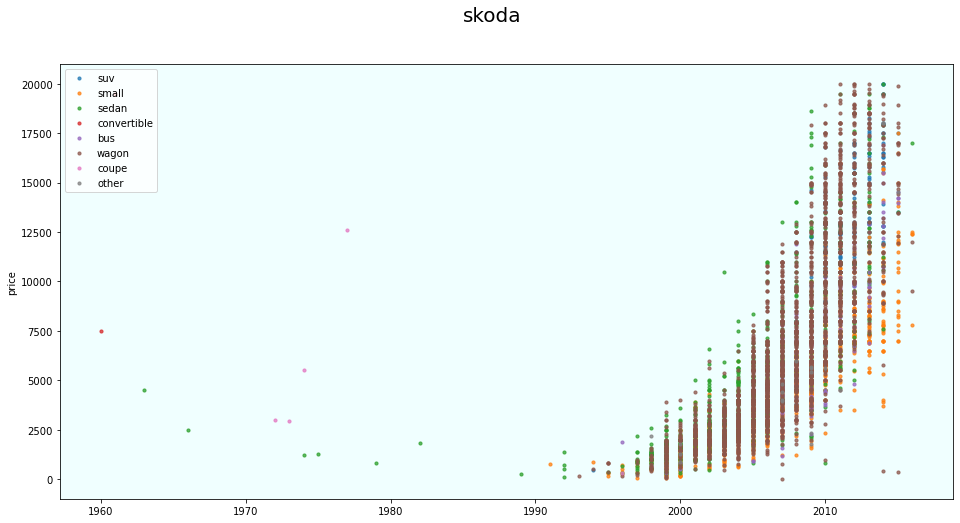

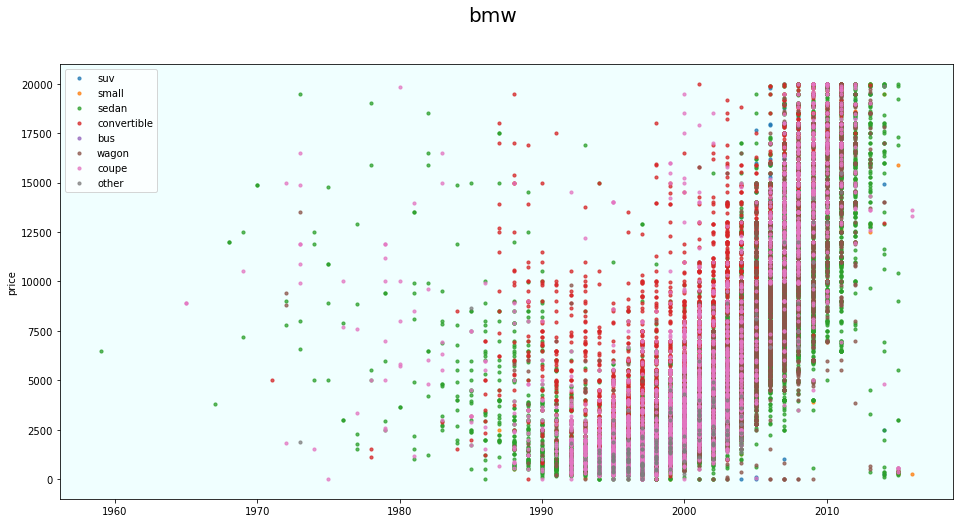

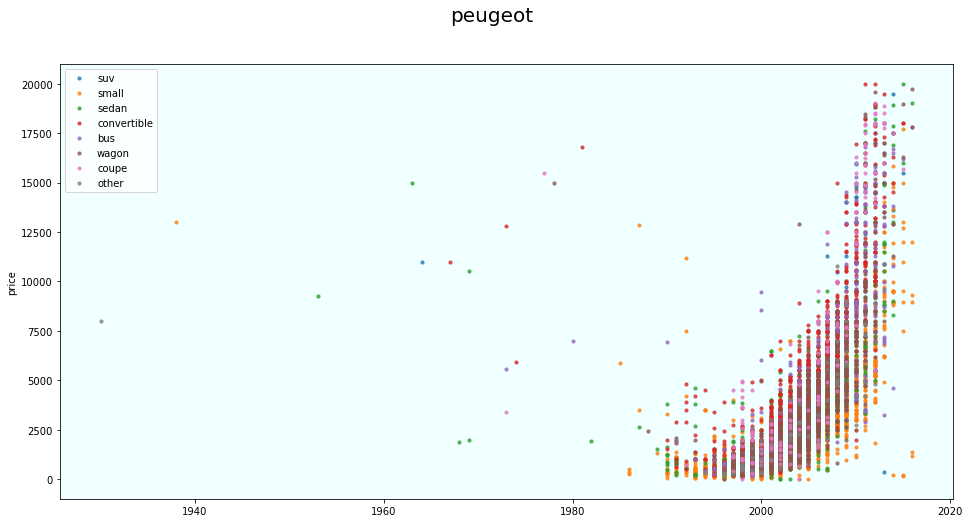

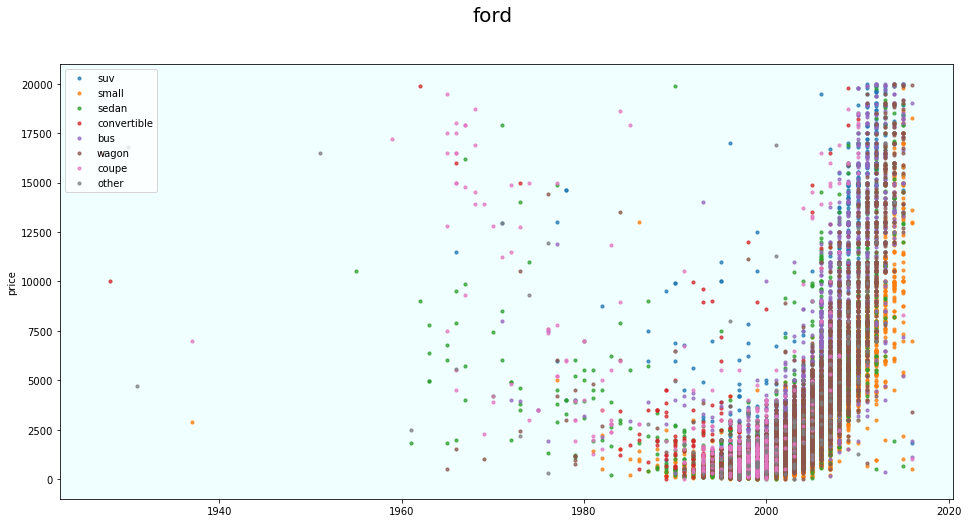

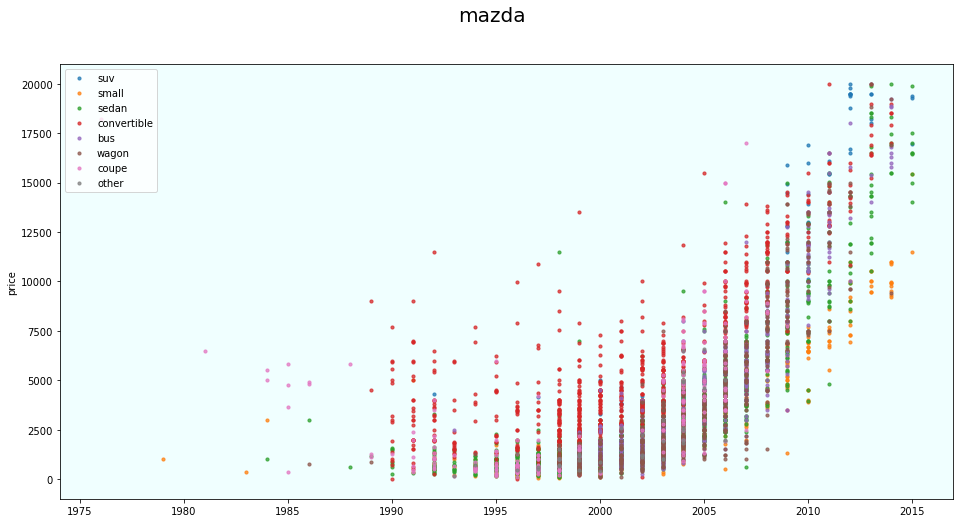

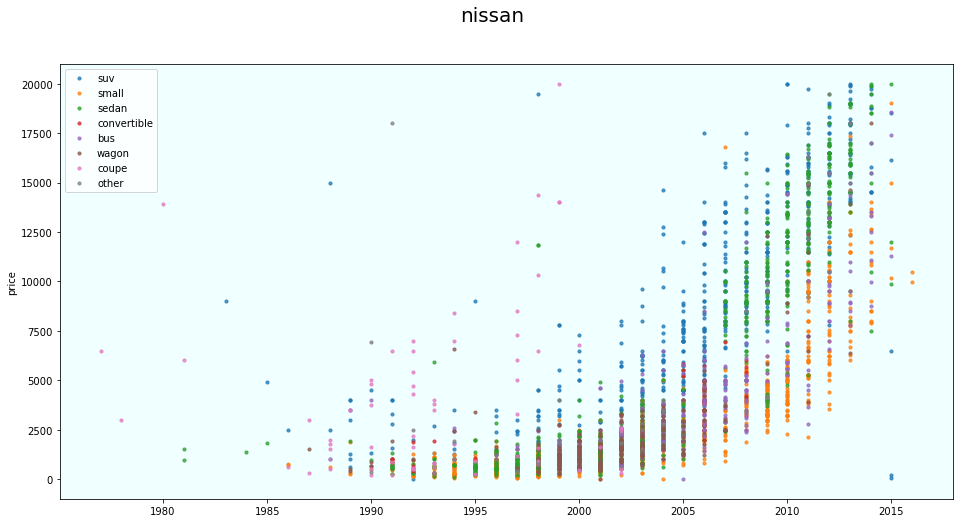

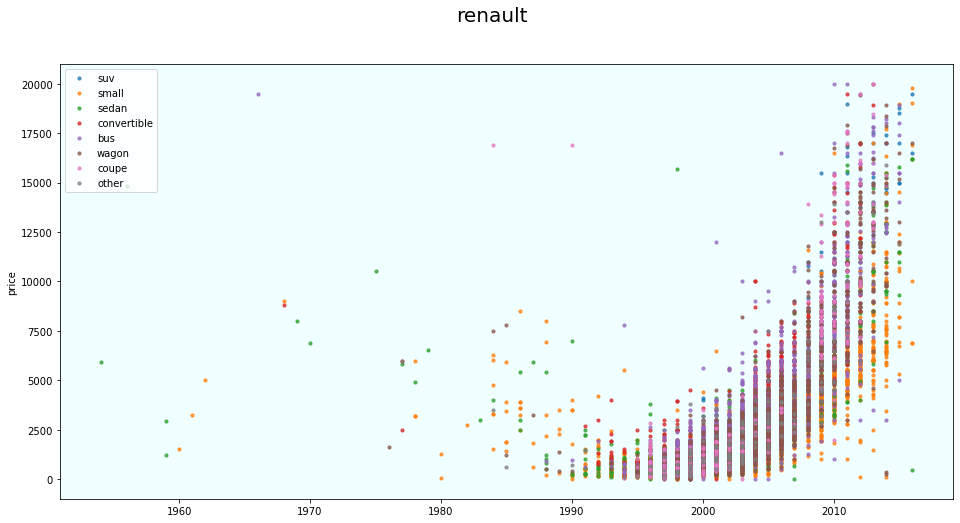

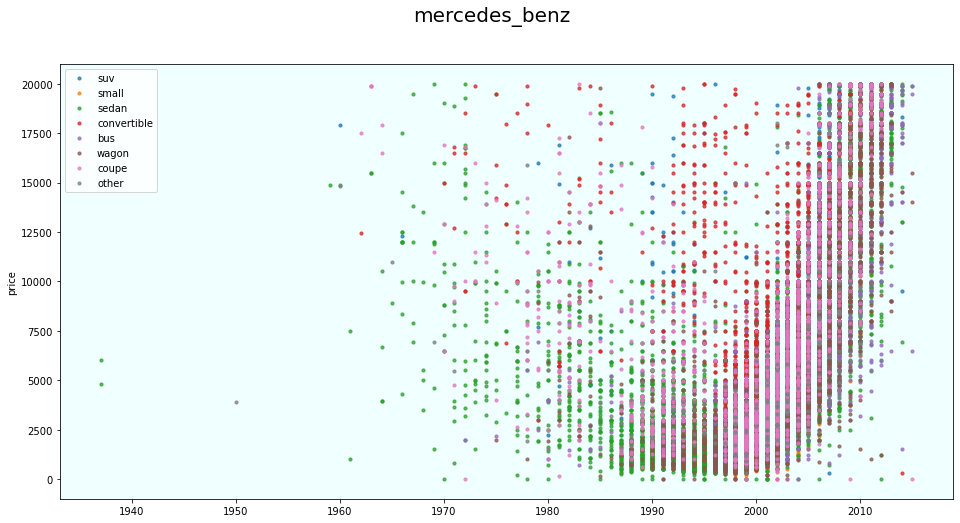

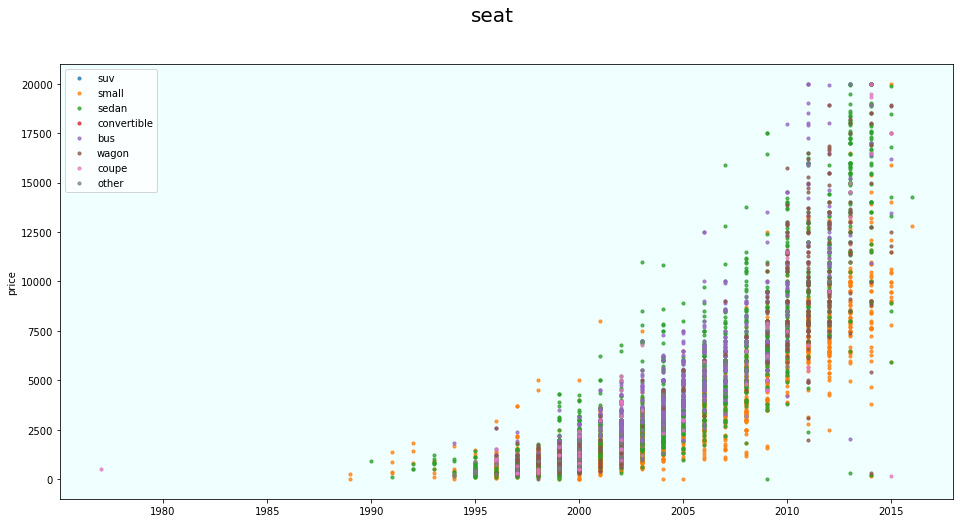

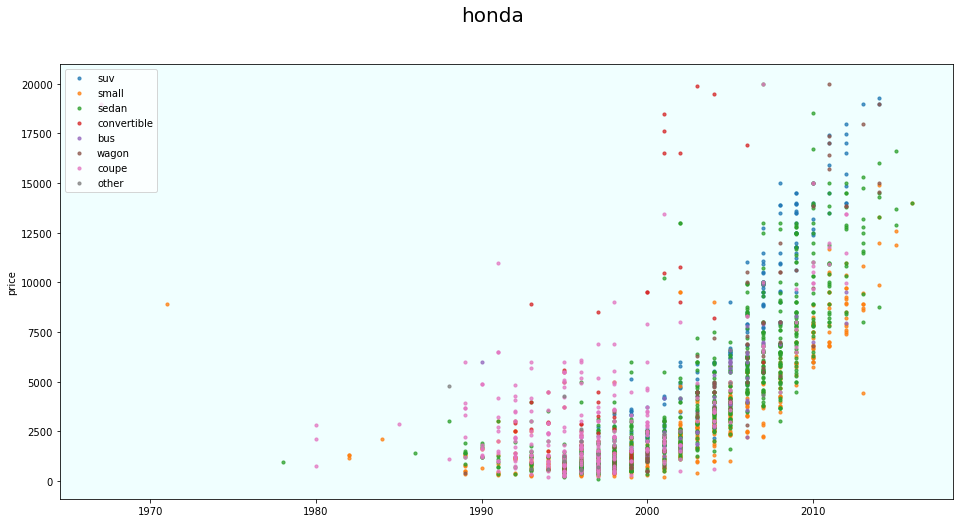

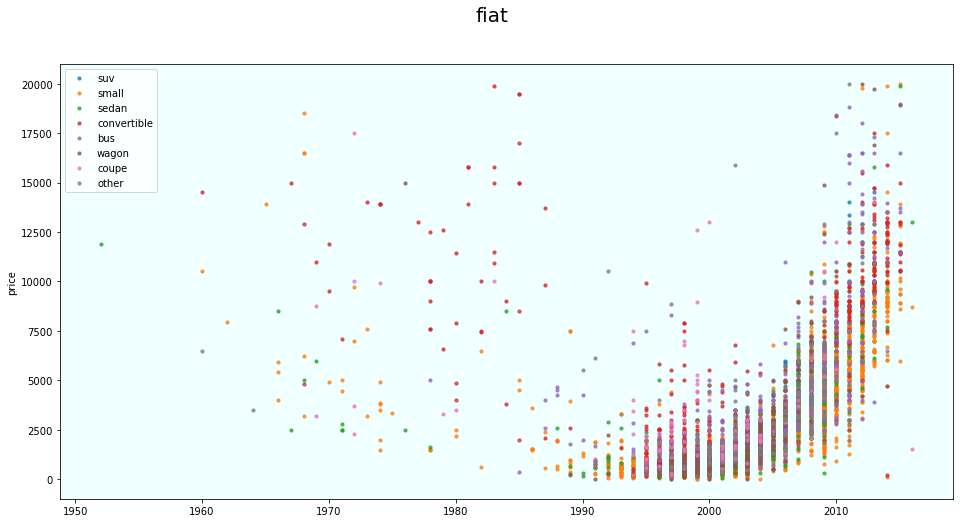

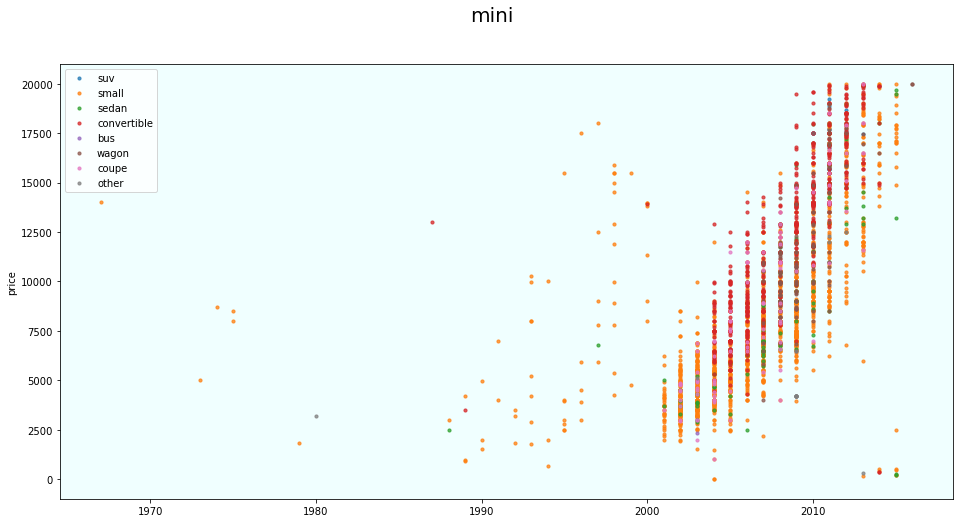

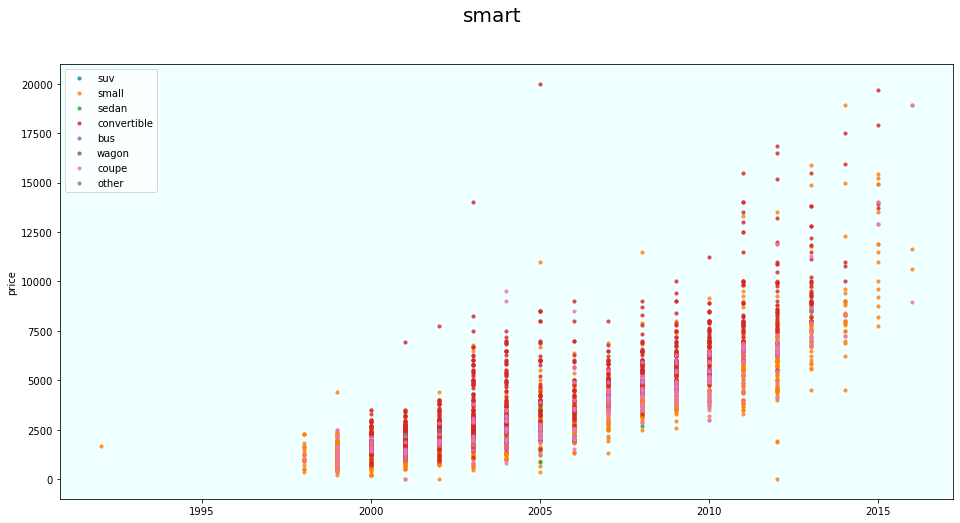

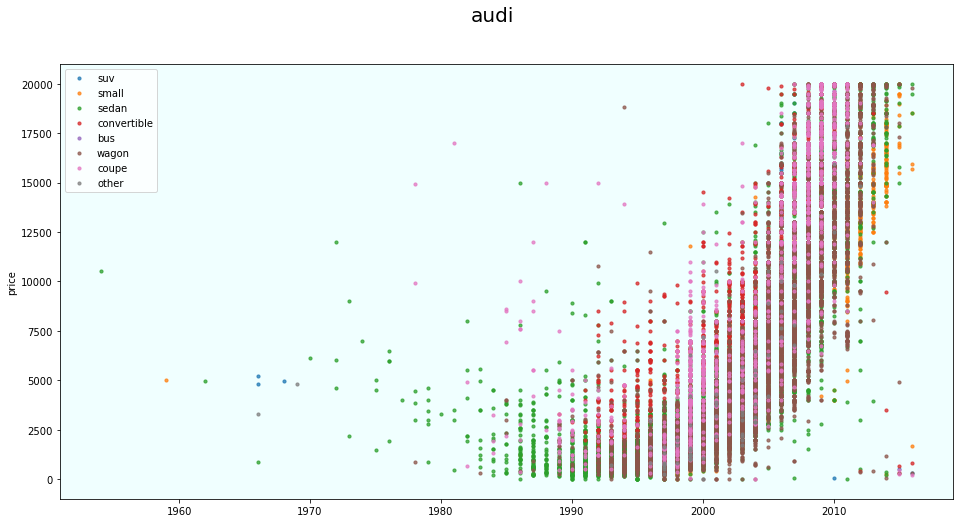

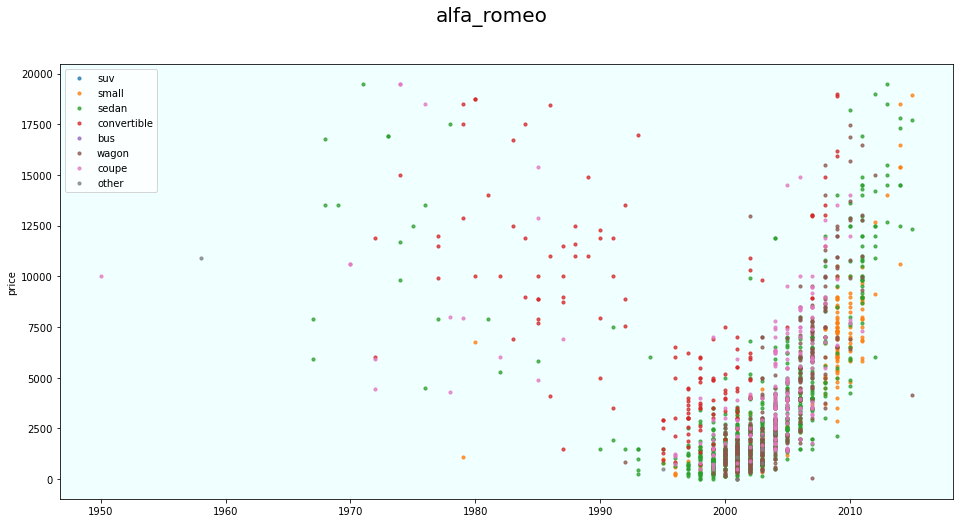

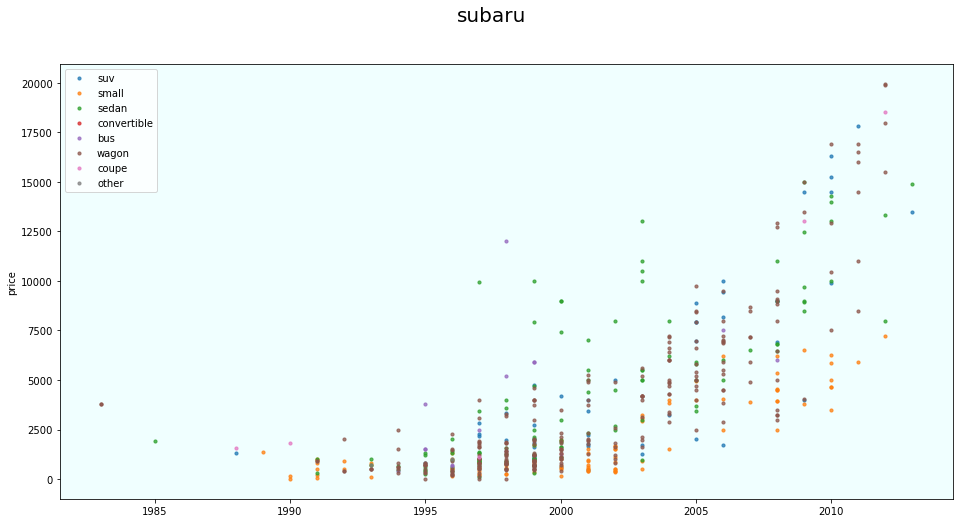

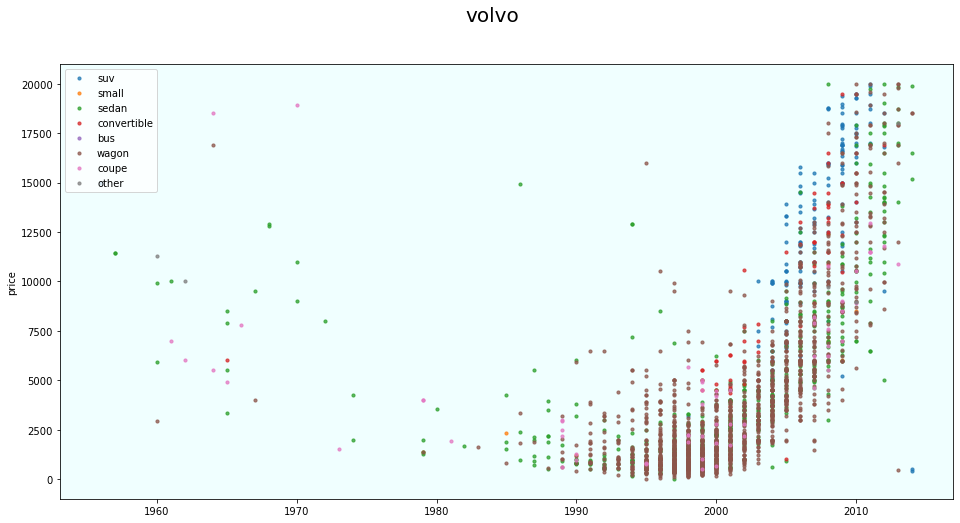

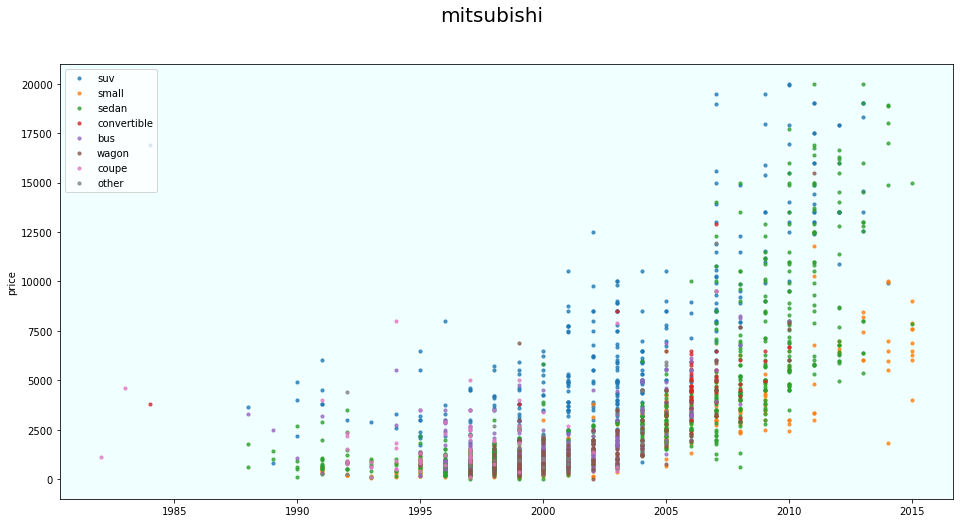

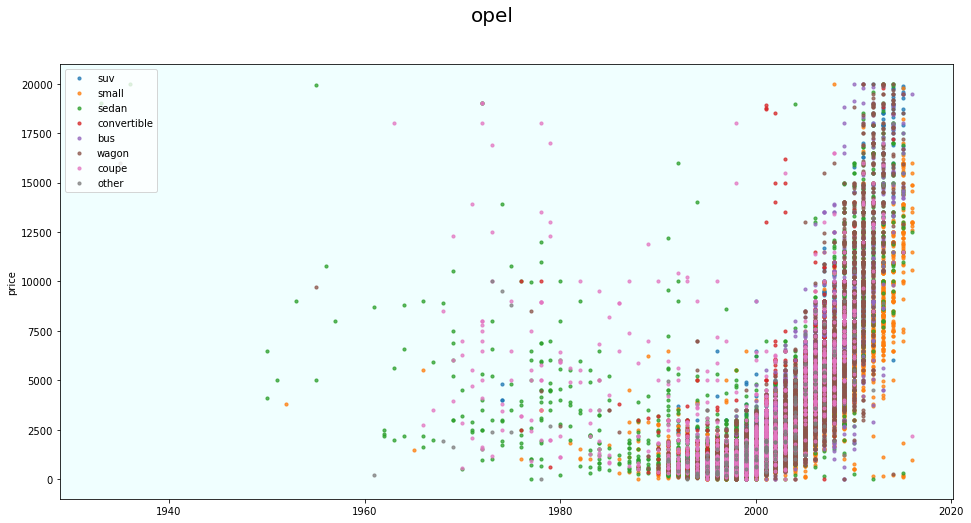

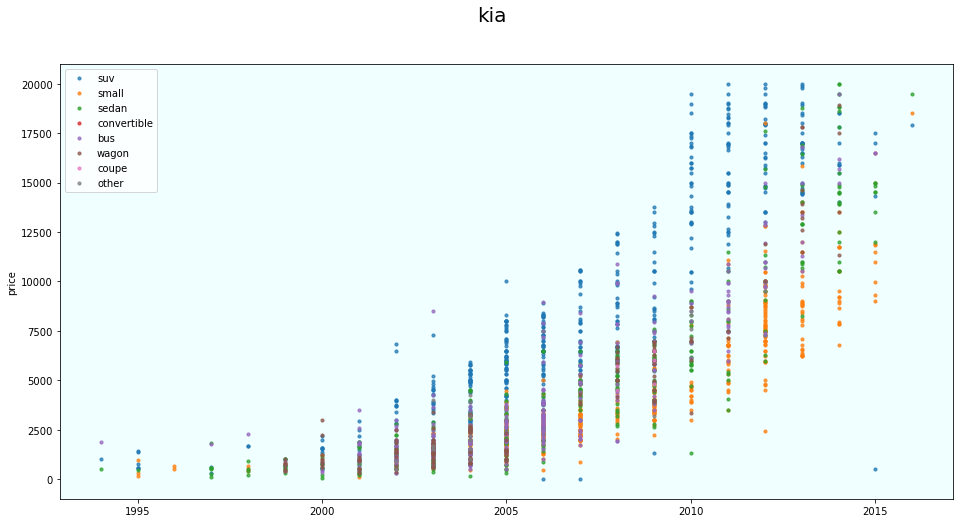

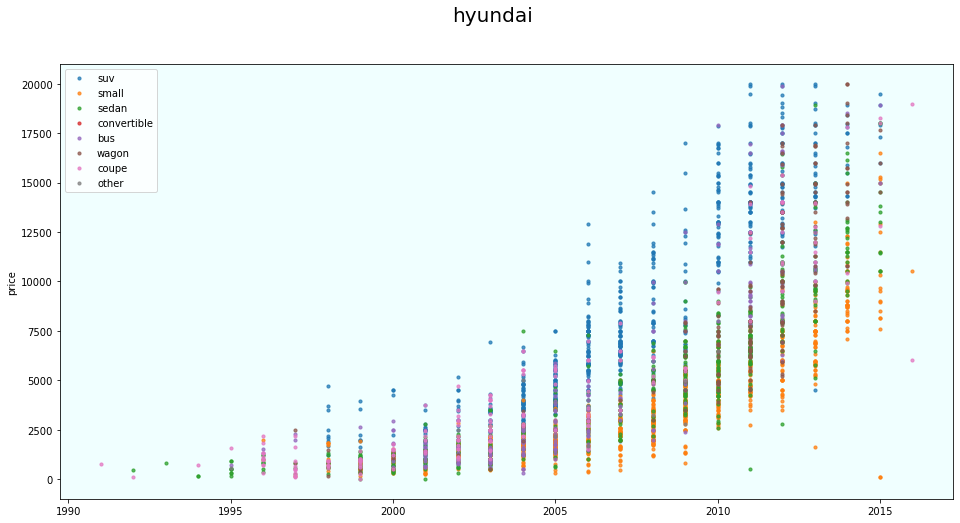

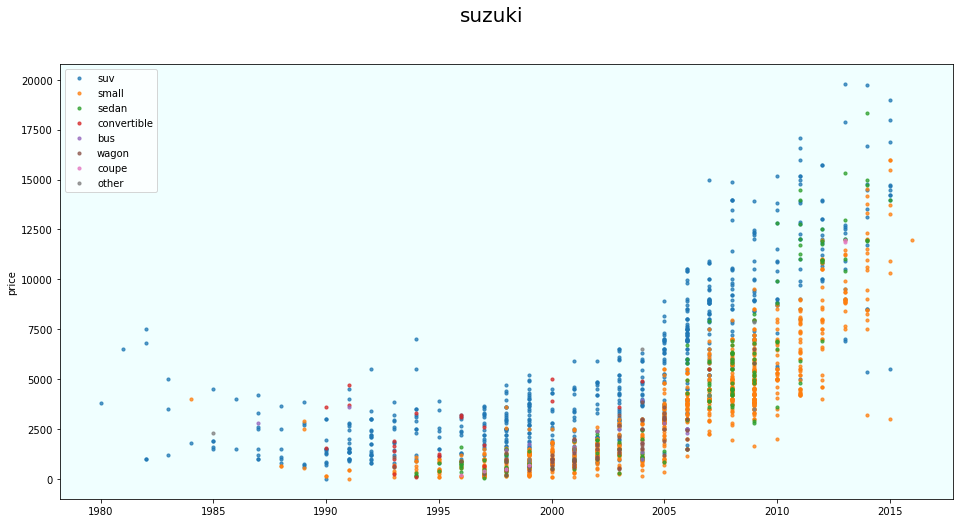

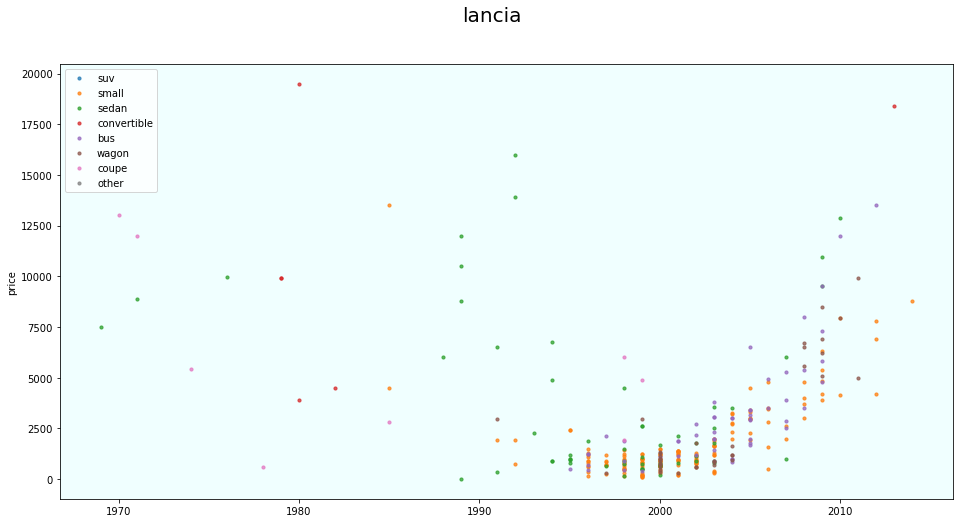

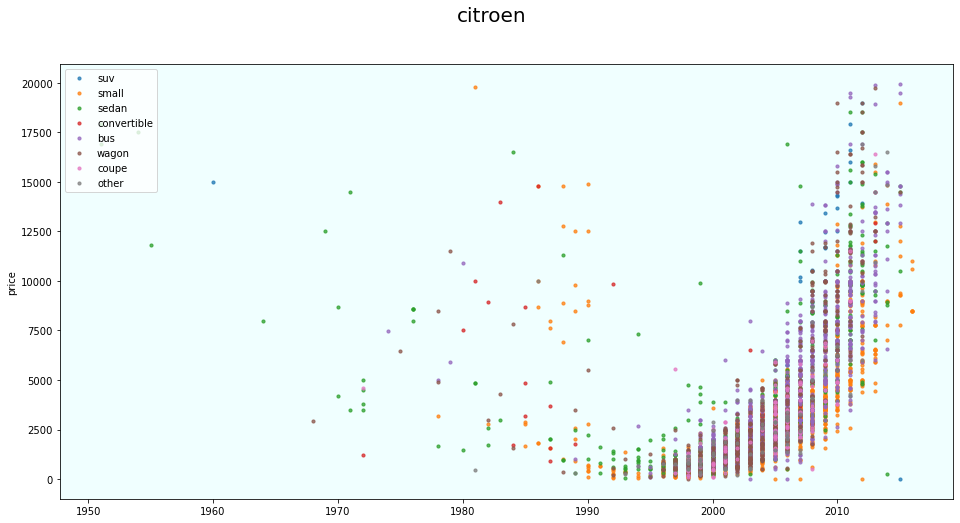

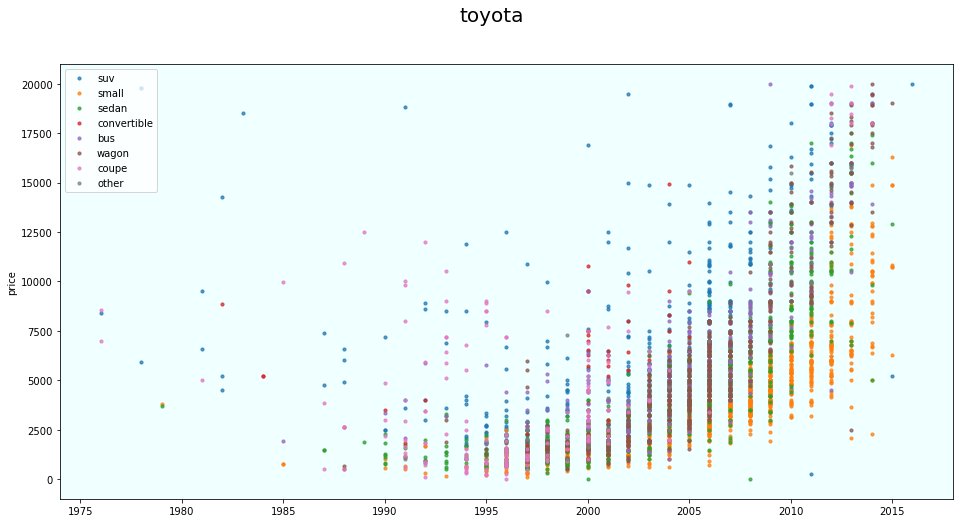

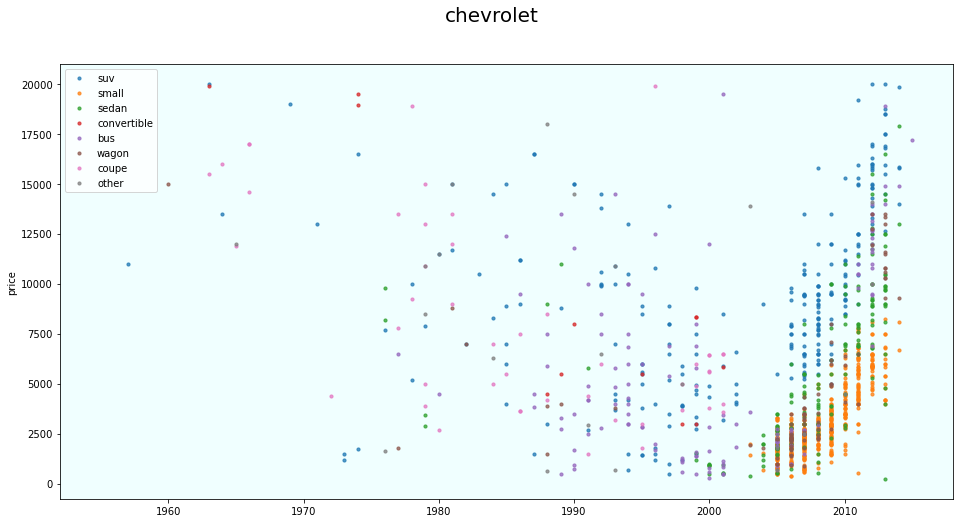

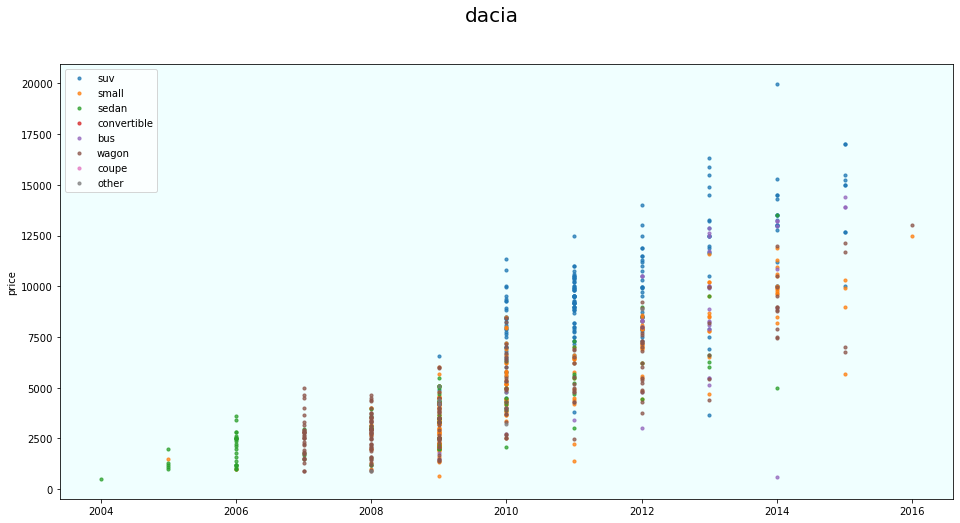

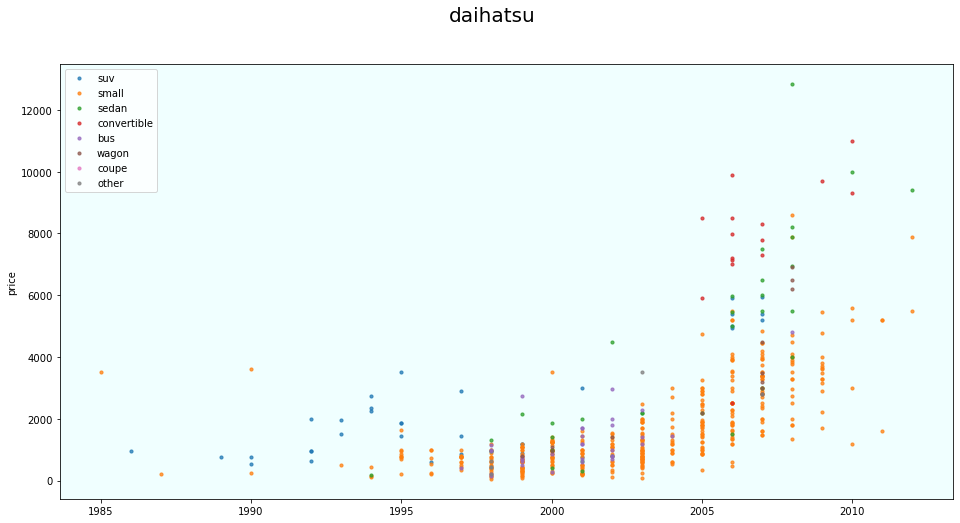

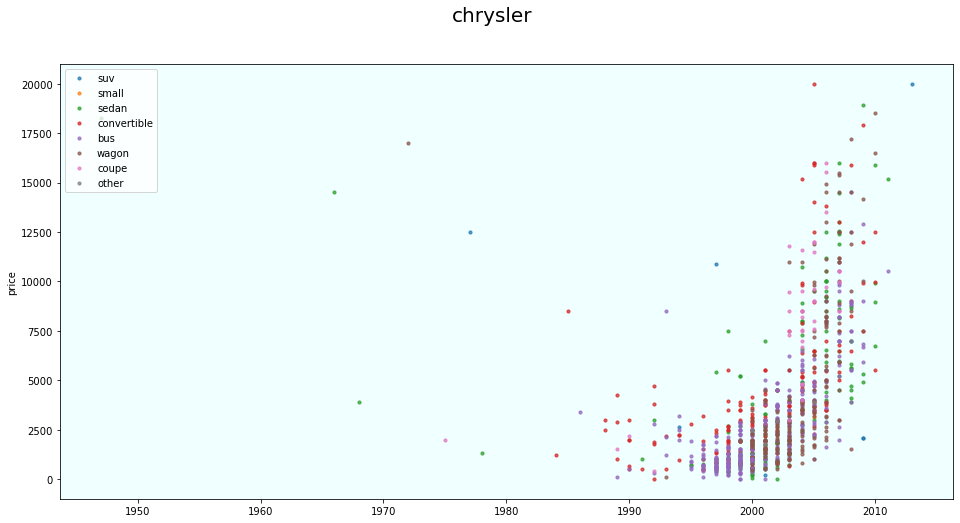

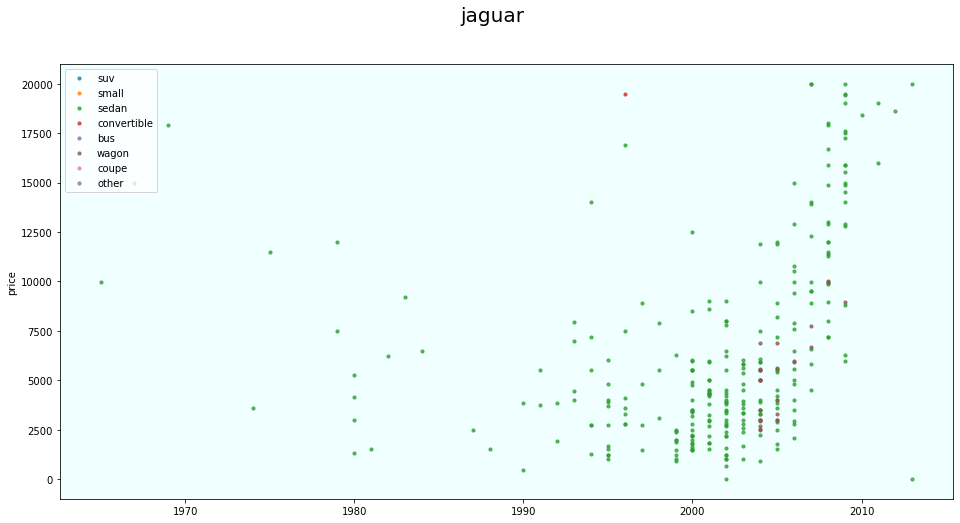

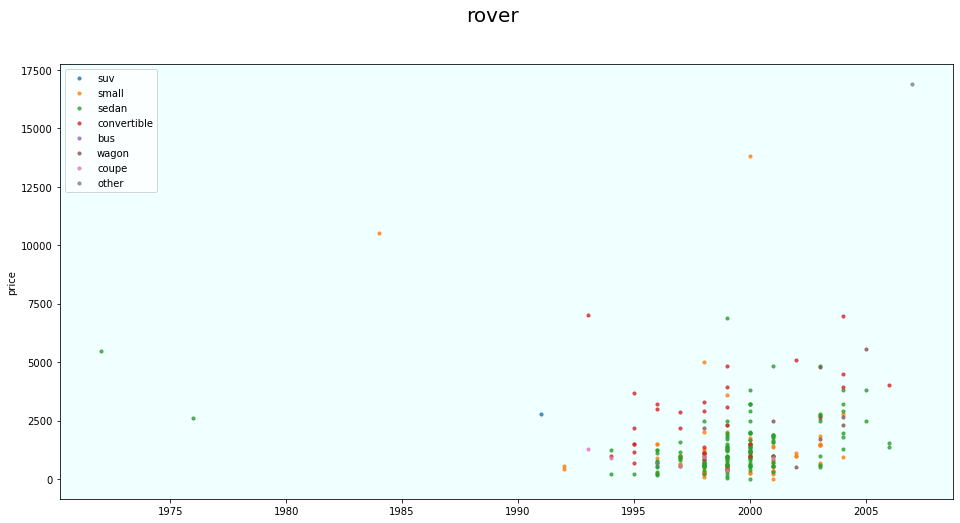

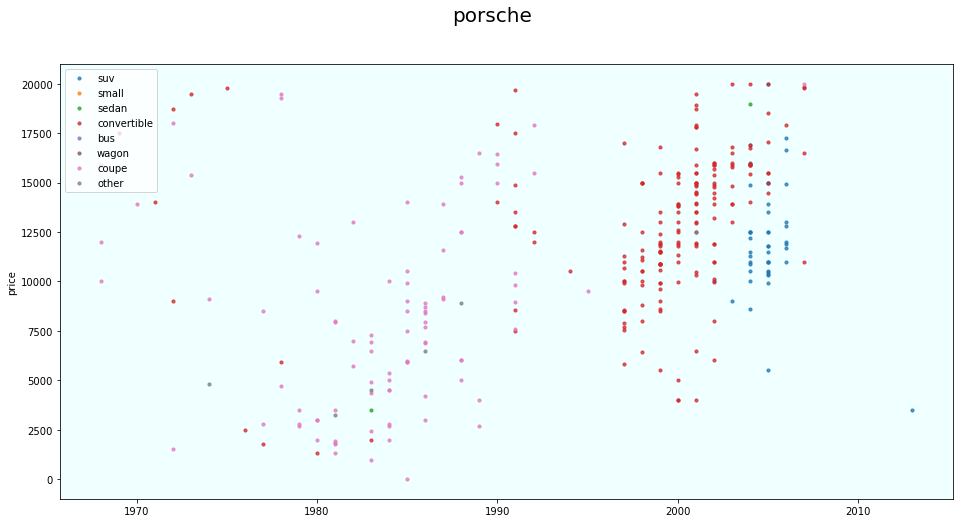

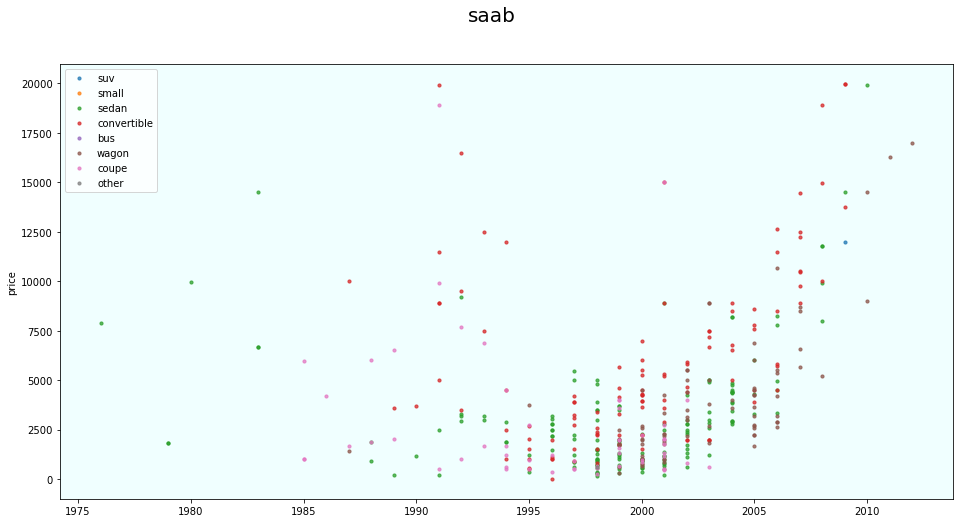

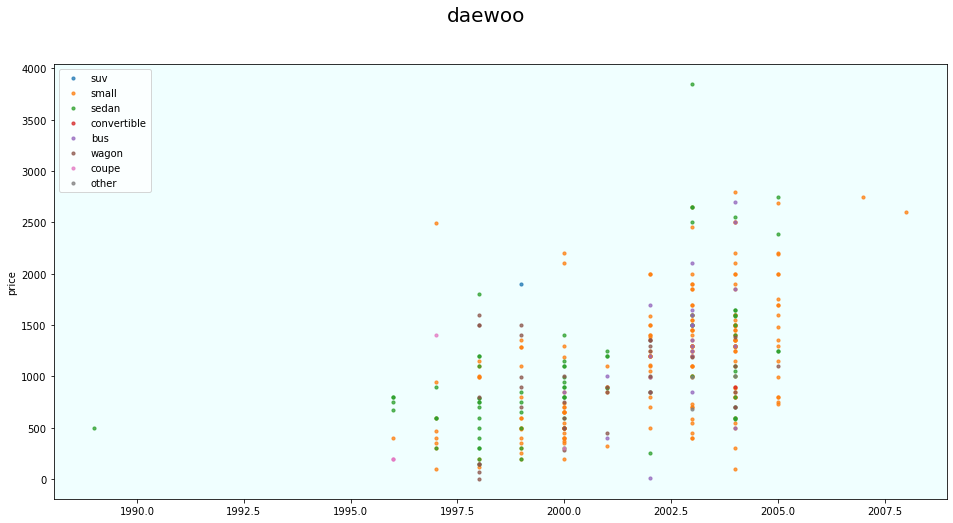

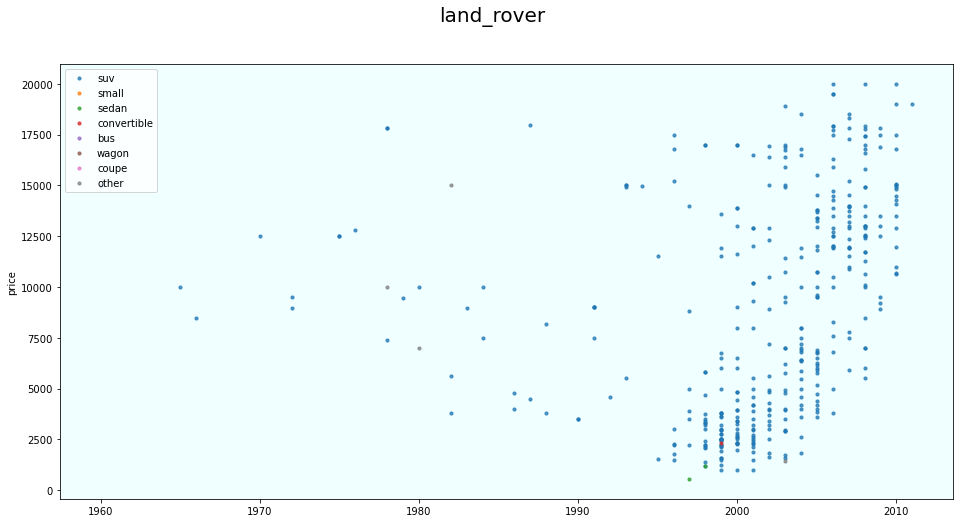

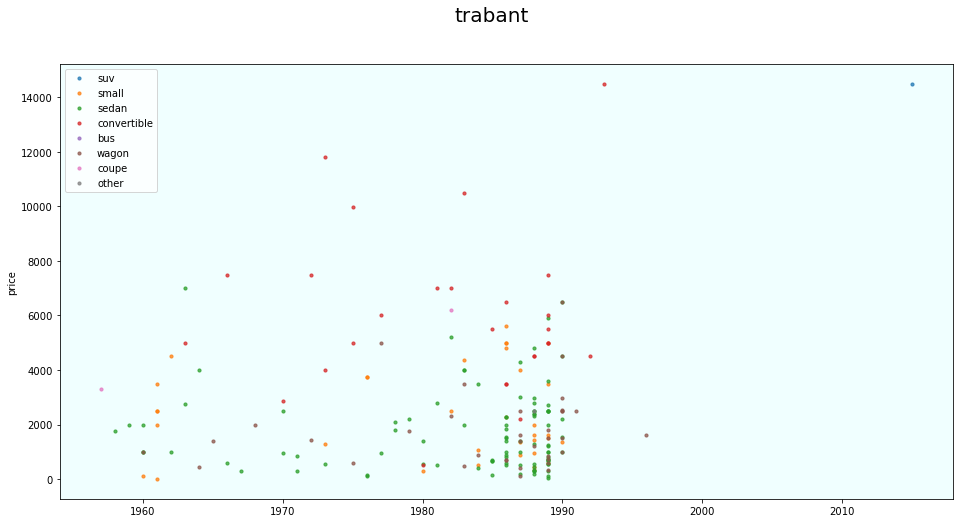

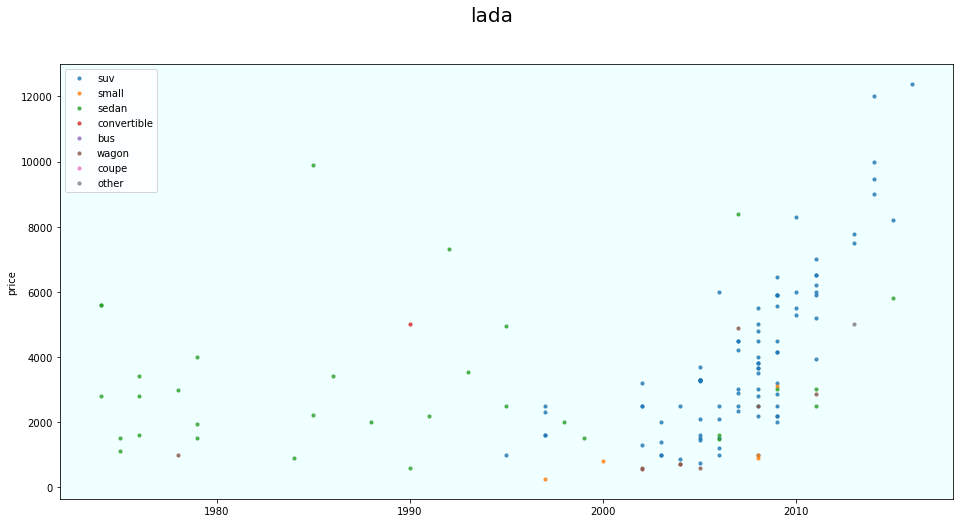

In [30]:
dependence (df, 'registration_year', 'brand', 'vehicle_type', 'price')

У брендов разное распределение цен по типу кузова, есть бренды выпускающие только один тип кузова.

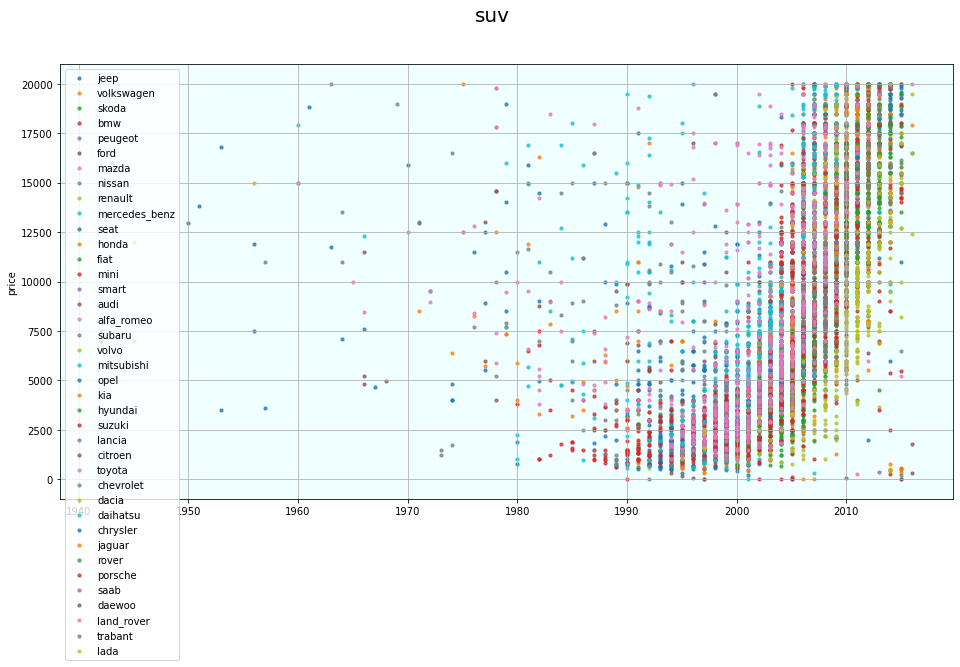

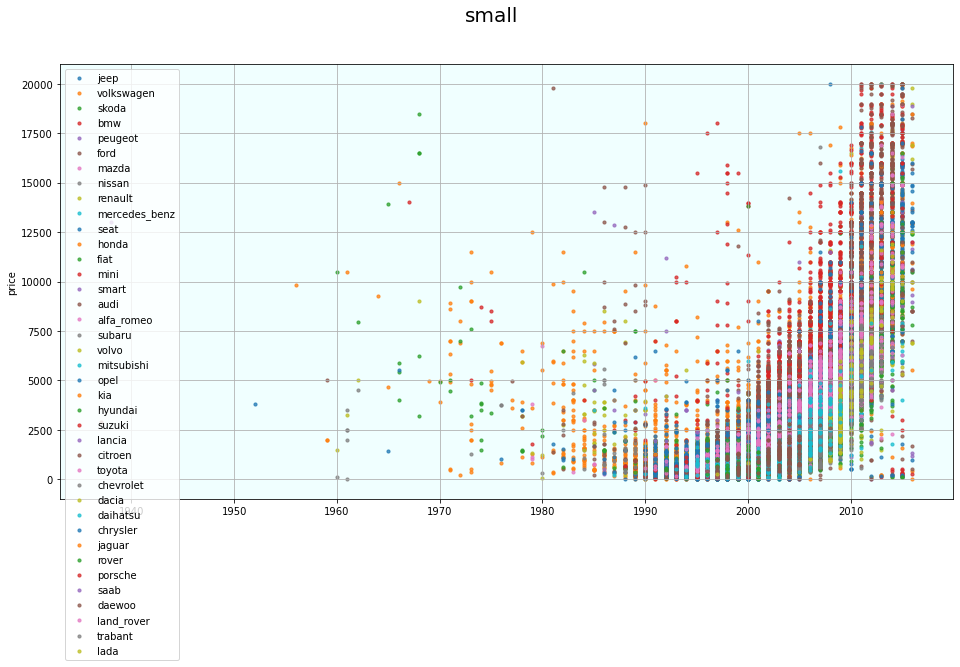

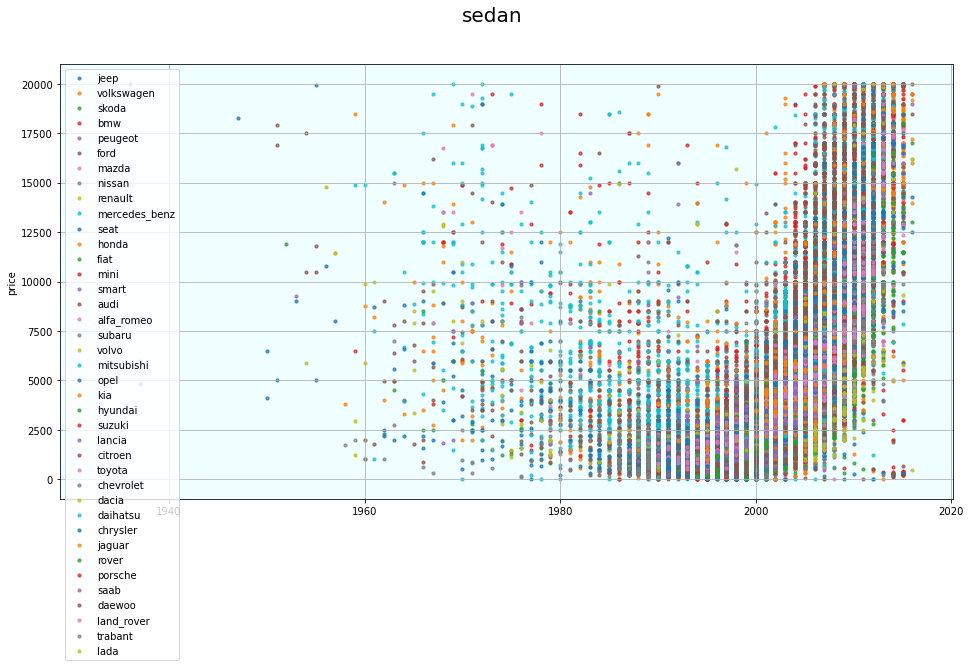

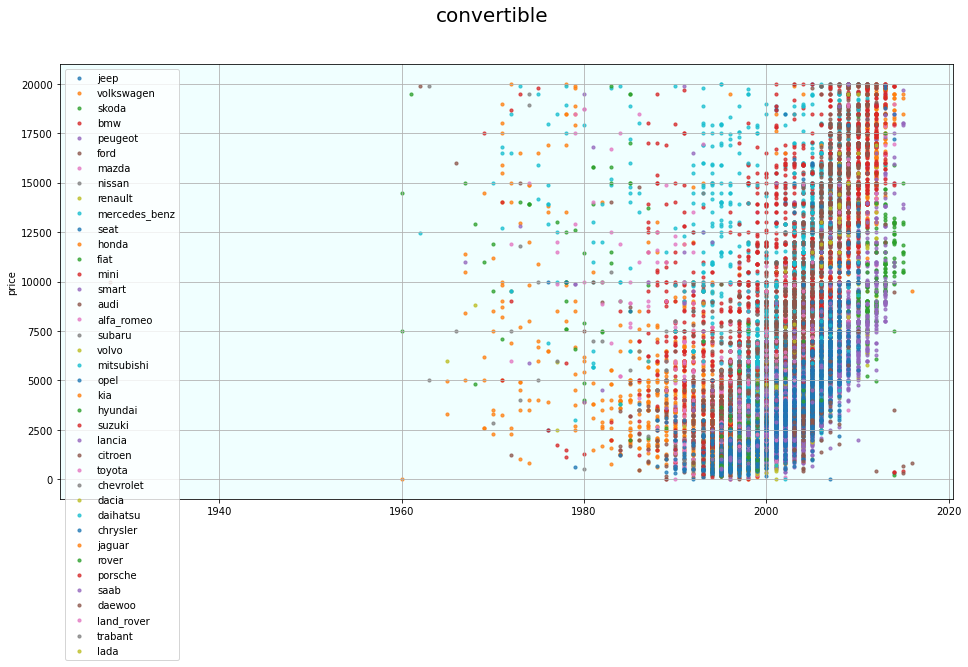

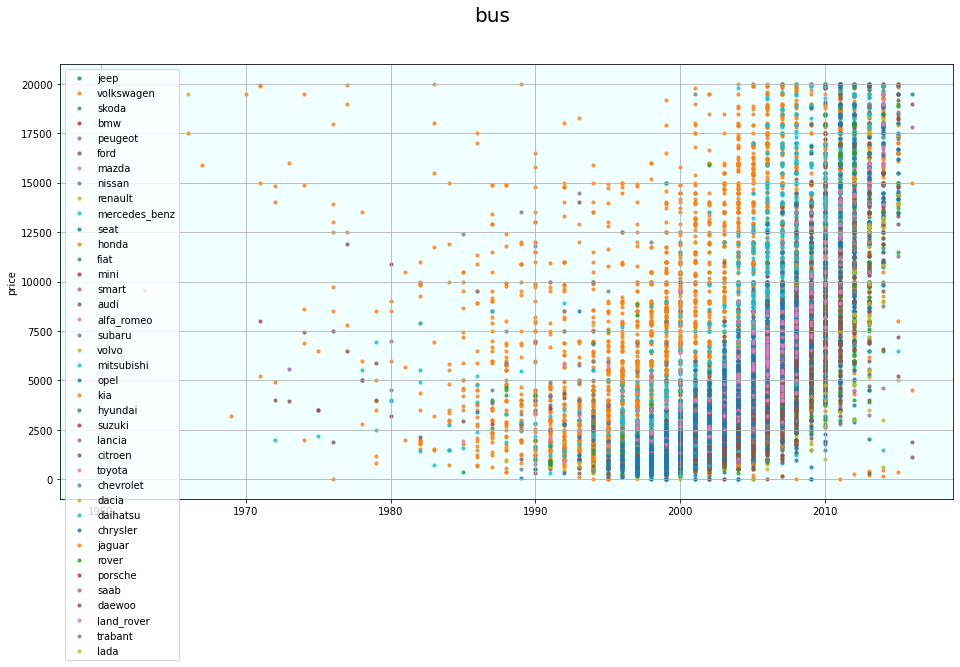

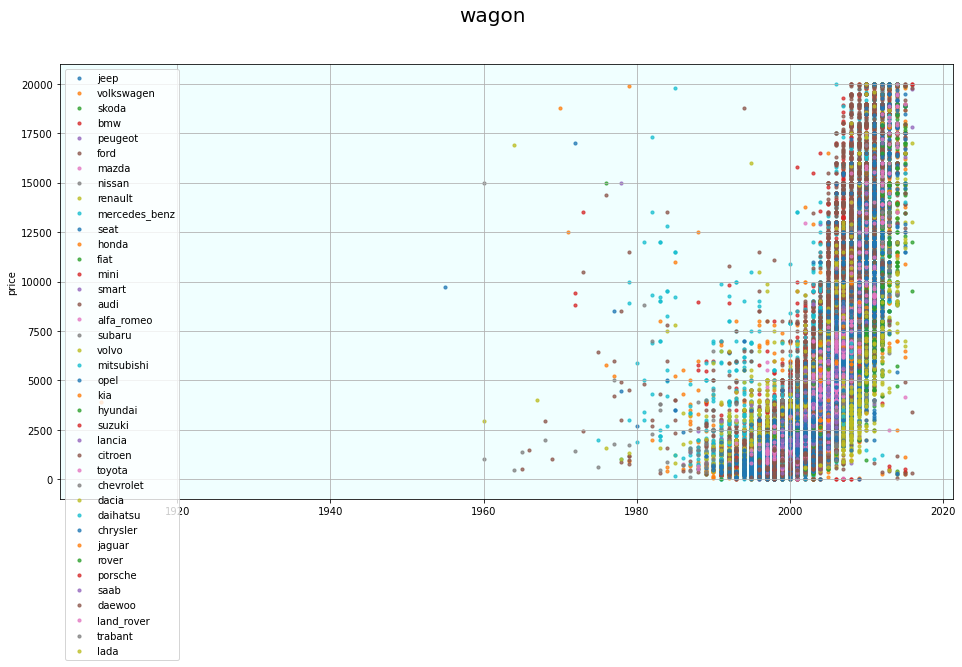

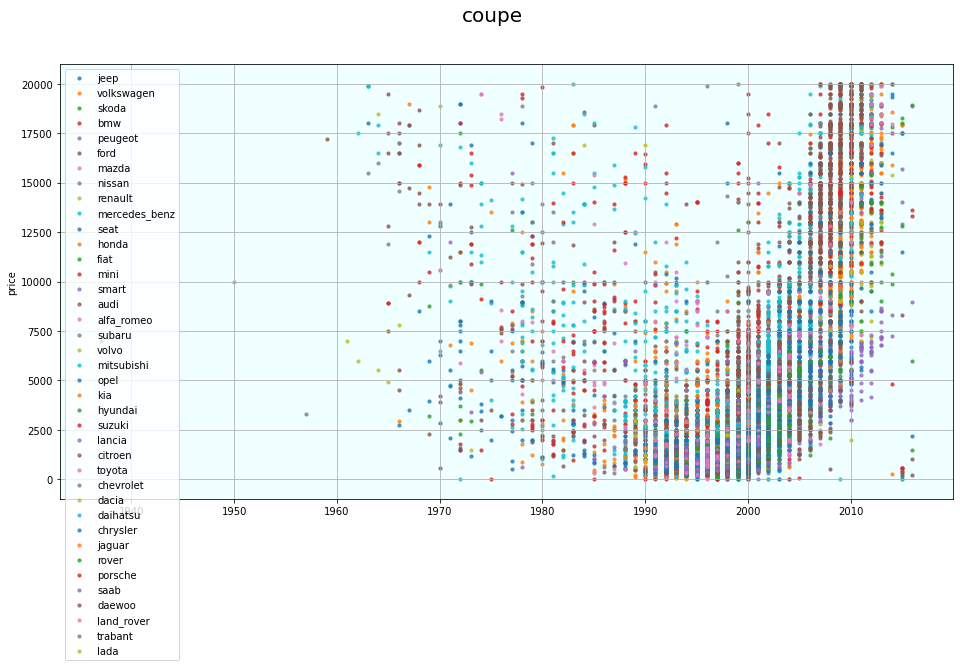

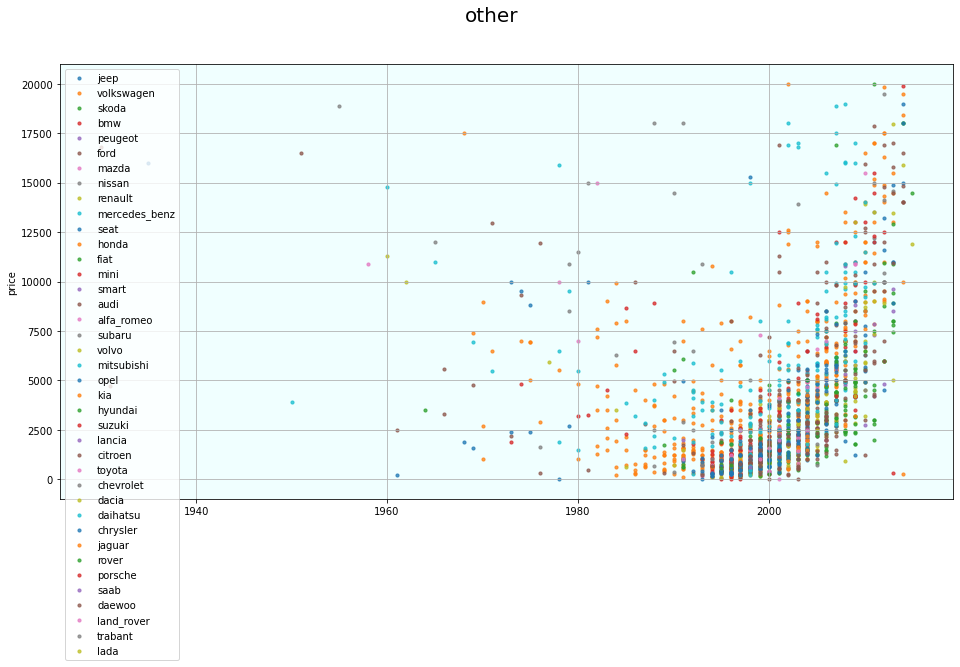

In [31]:
dependence (df, 'registration_year', 'vehicle_type','brand', 'price')

Тип кузова существенно влияет на цену продажи

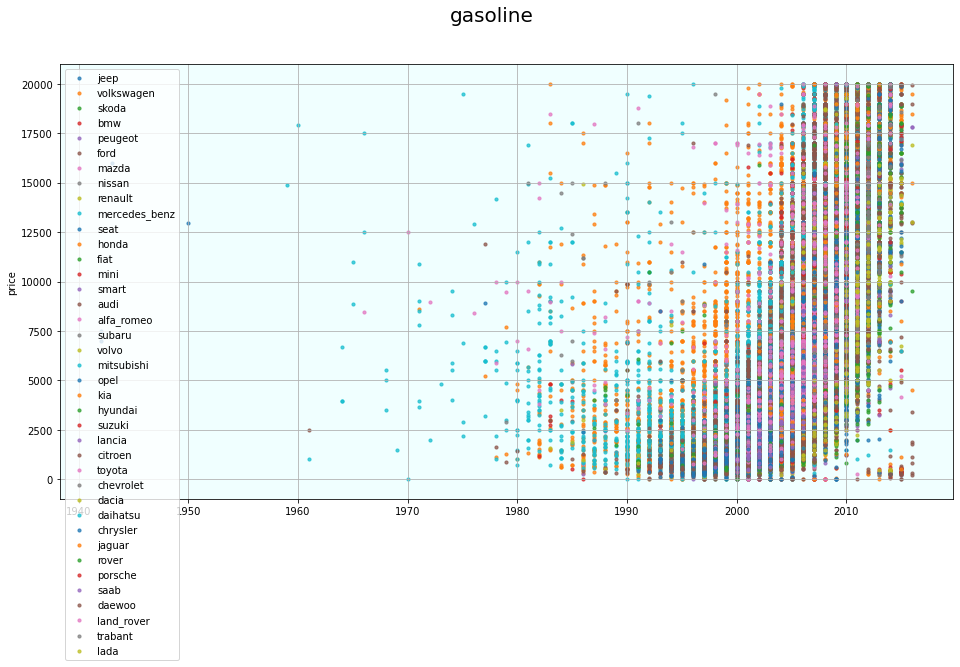

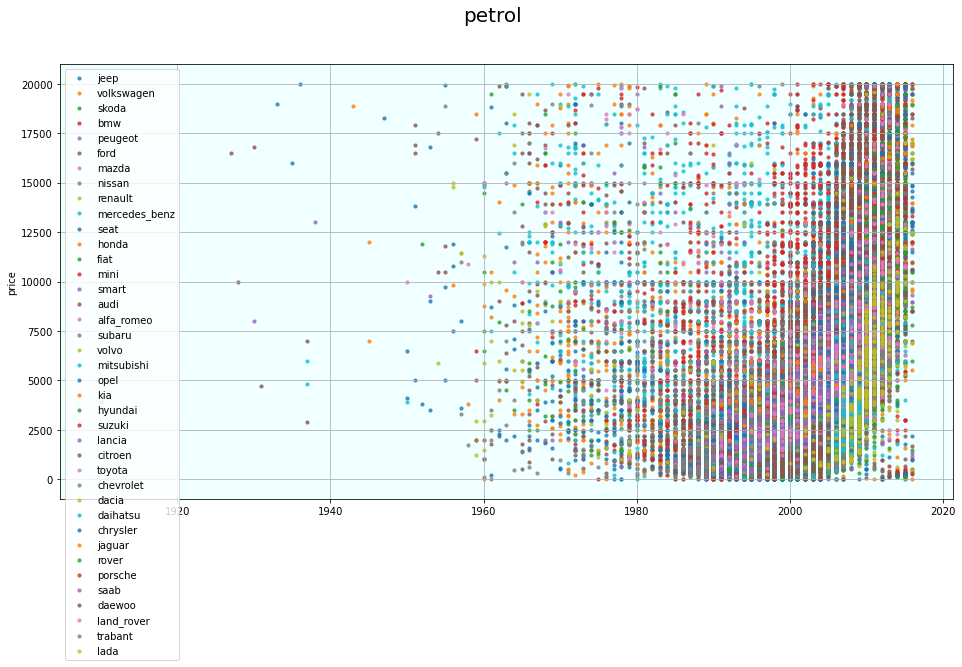

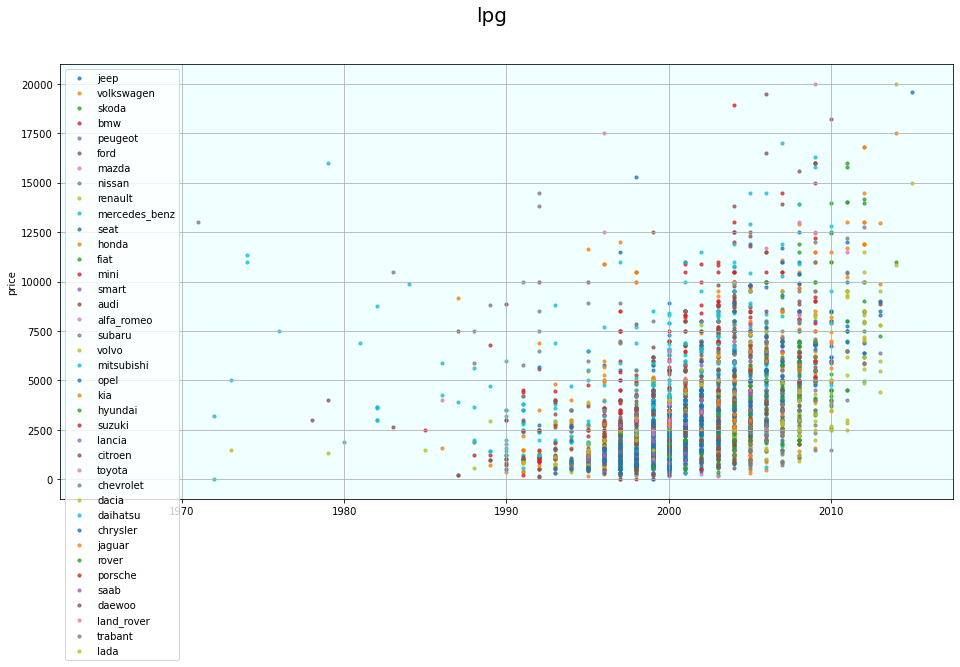

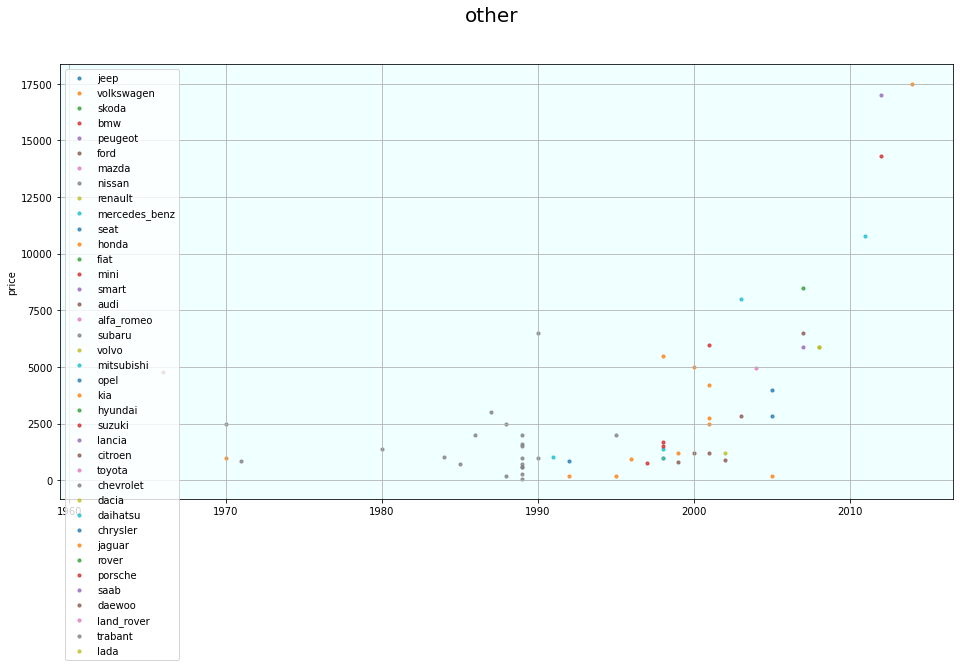

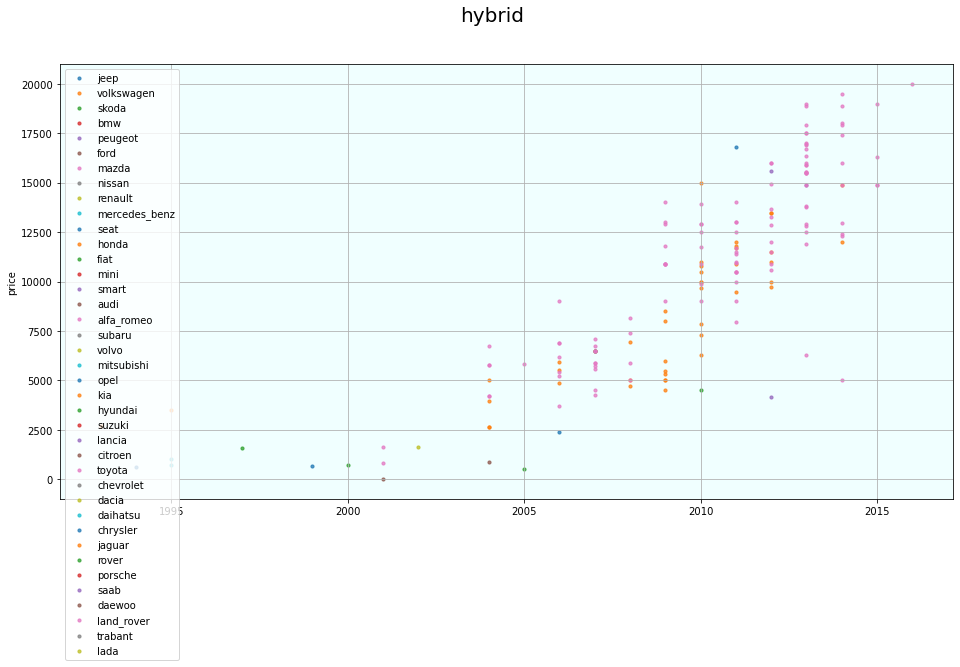

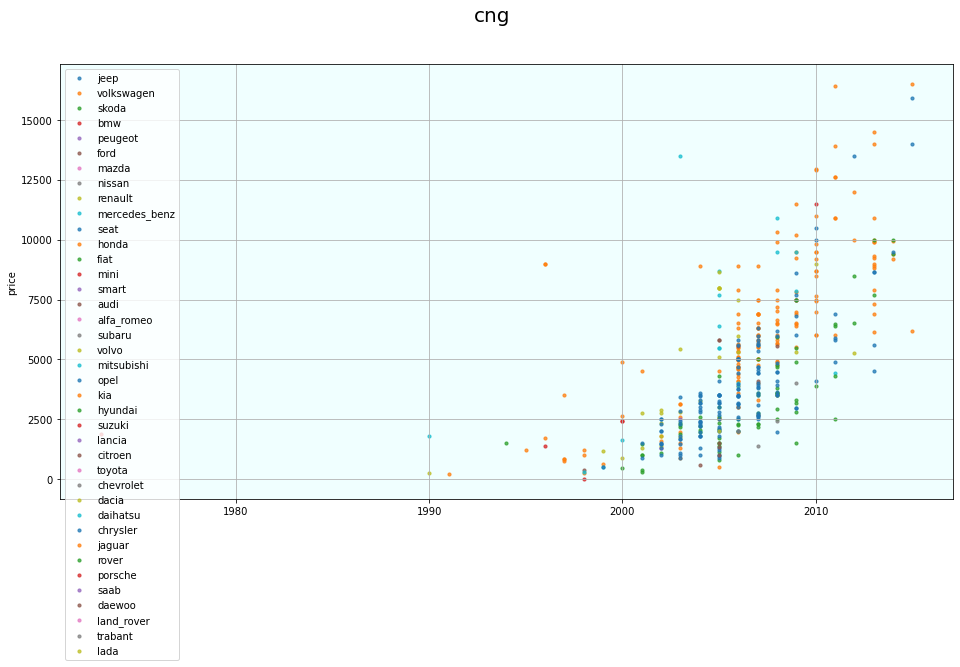

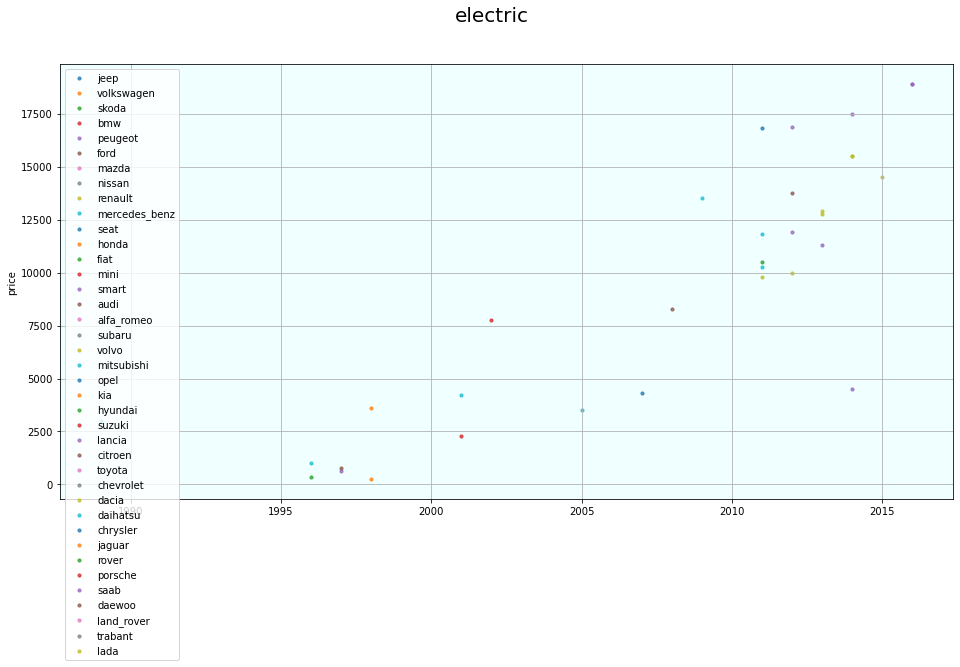

In [32]:
dependence (df, 'registration_year', 'fuel_type','brand', 'price')

Экзотические виды топлива менее востребованны чем бензин

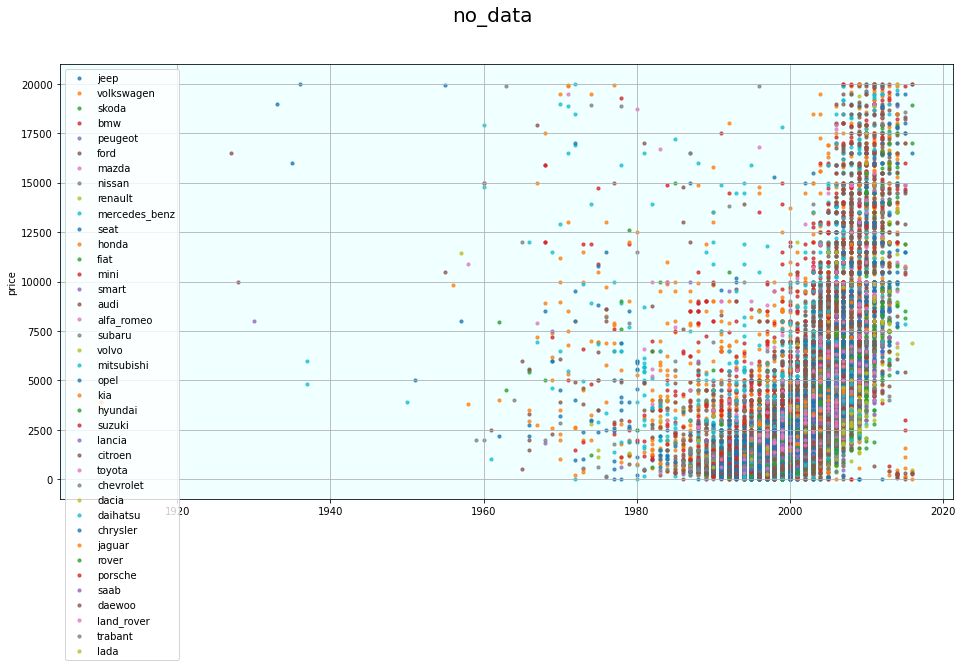

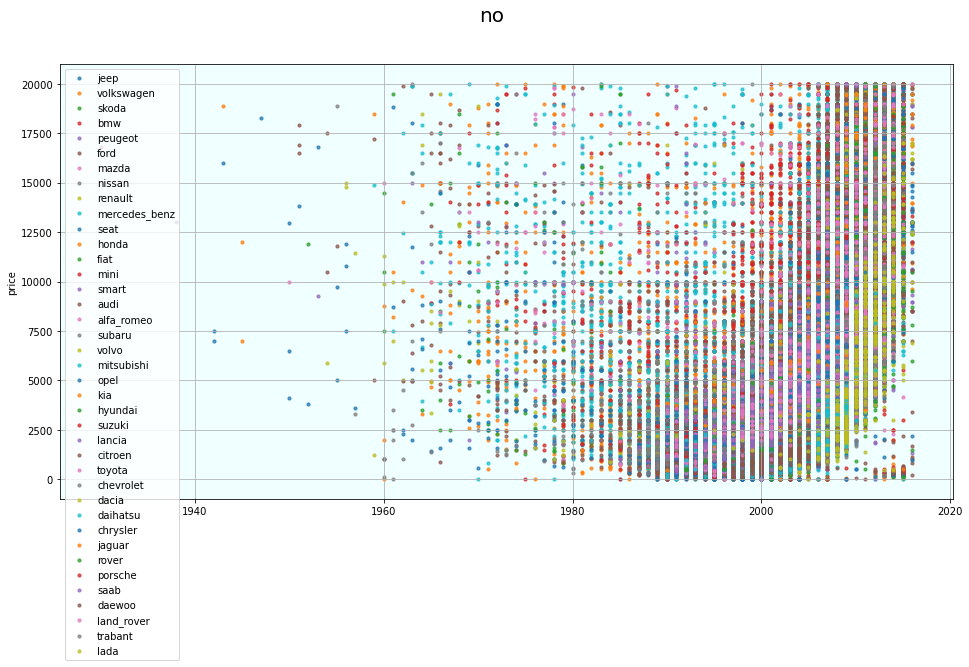

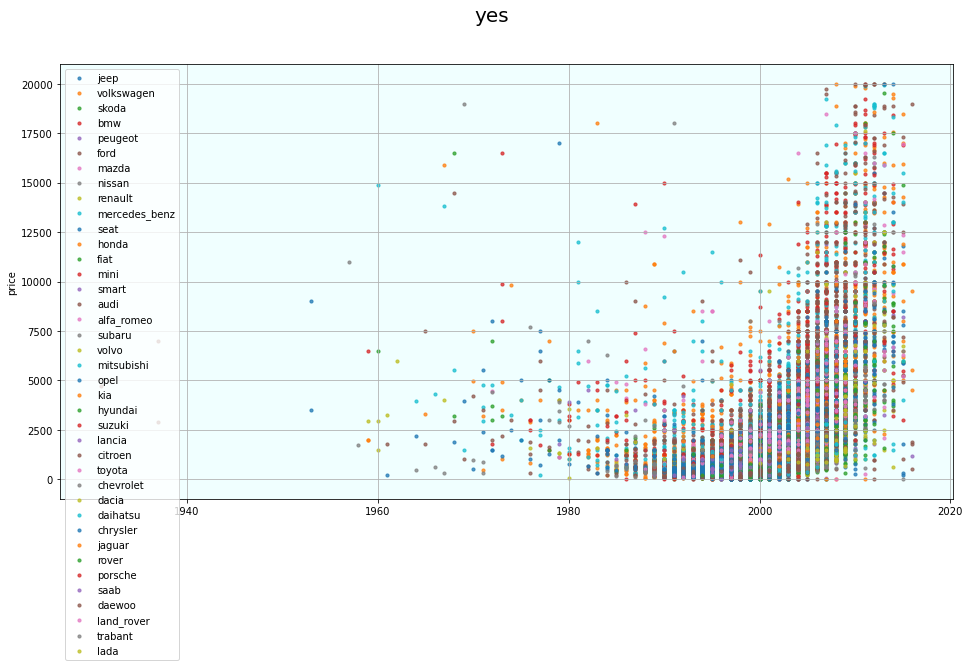

In [34]:
dependence (df, 'registration_year', 'not_repaired','brand', 'price')

Очевидно что повреждения авто снижают его стоимость.

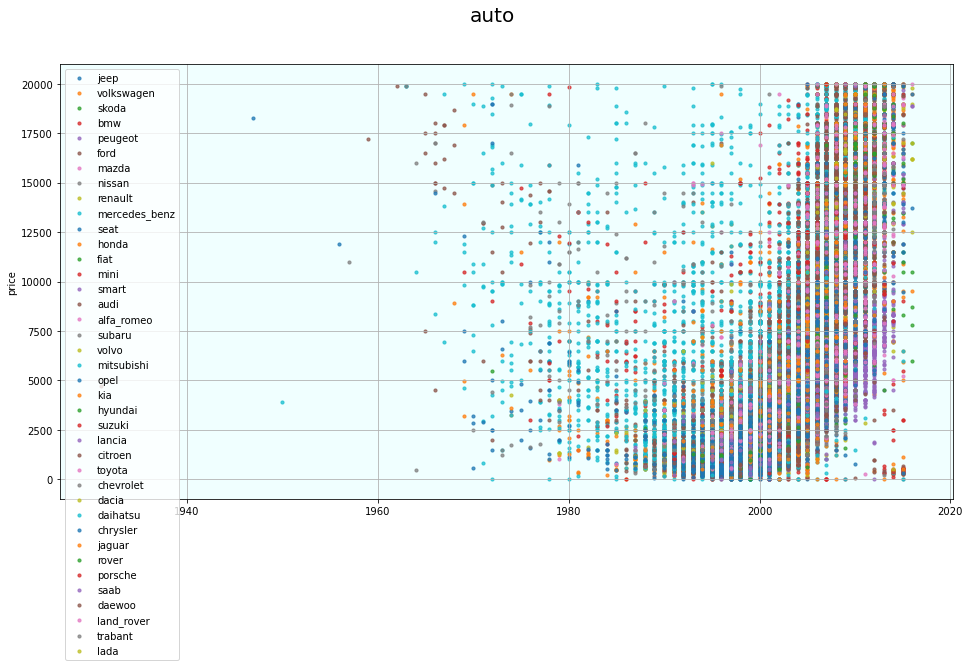

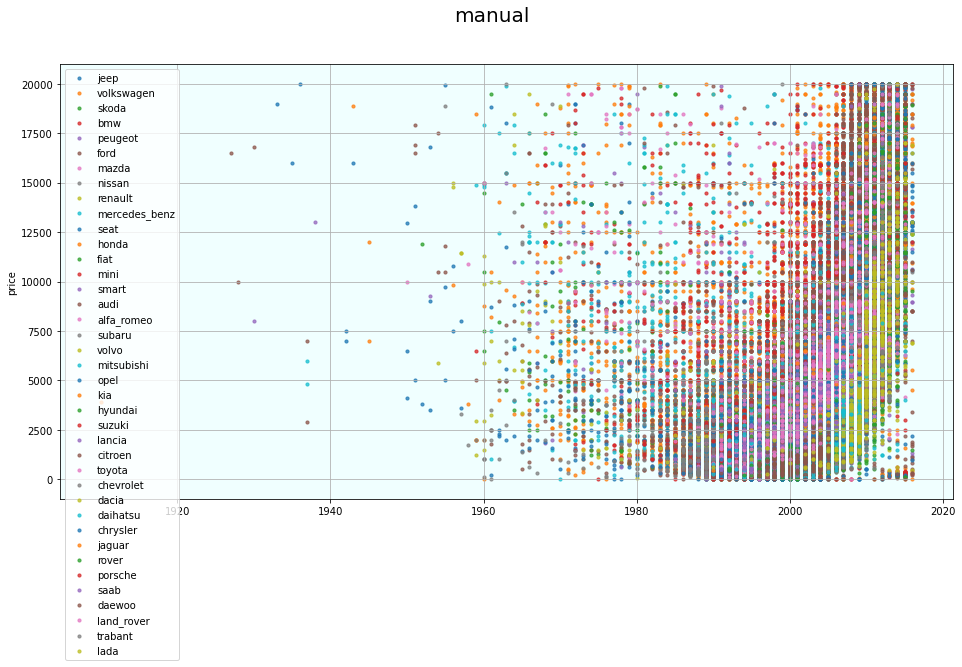

In [35]:
dependence (df, 'registration_year', 'gearbox','brand', 'price')

Тип коробки передач влияет на стоимость, но вероятно так же и что автоматические коробки передач стали производить более массово позже и в период 1980-2000г преобладала механика

####  Анализ по группам  <a id='group'></a>

In [36]:
def group_diagr(data, col):
    fig,ax = plt.subplots(1,4,figsize = (18,12))
    data.groupby(col)['kilometer'].mean().plot(ax=ax[0],
                                         kind='bar', 
                                         figsize=(16,8), 
                                         grid=True,
                                         title='Mean kilometr, km',
                                         alpha=0.75)
    data.groupby(col)['power'].mean().plot(ax=ax[1],
                                         kind='bar', 
                                         figsize=(16,8), 
                                         grid=True,
                                         title='Mean power, hp',
                                         alpha=0.75)
    data.groupby(col)['price'].mean().plot(ax=ax[2],
                                         kind='bar', 
                                         figsize=(16,8), 
                                         grid=True,
                                         title='Mean price, €',
                                         alpha=0.75)
    data.groupby(col)['price'].median().plot(ax=ax[3],
                                         kind='bar', 
                                         figsize=(16,8), 
                                         grid=True,
                                         title='Median price, €',
                                         alpha=0.75)
    plt.show()

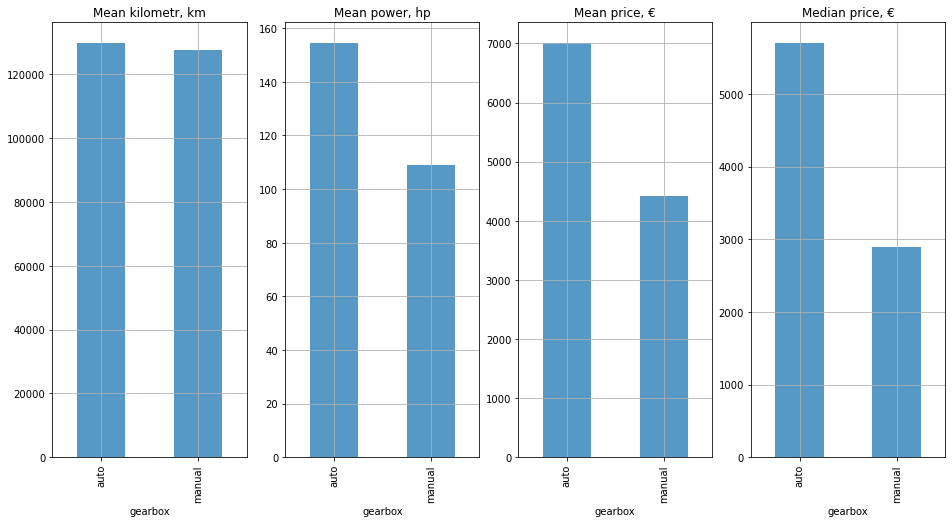

In [37]:
group_diagr(df, 'gearbox')

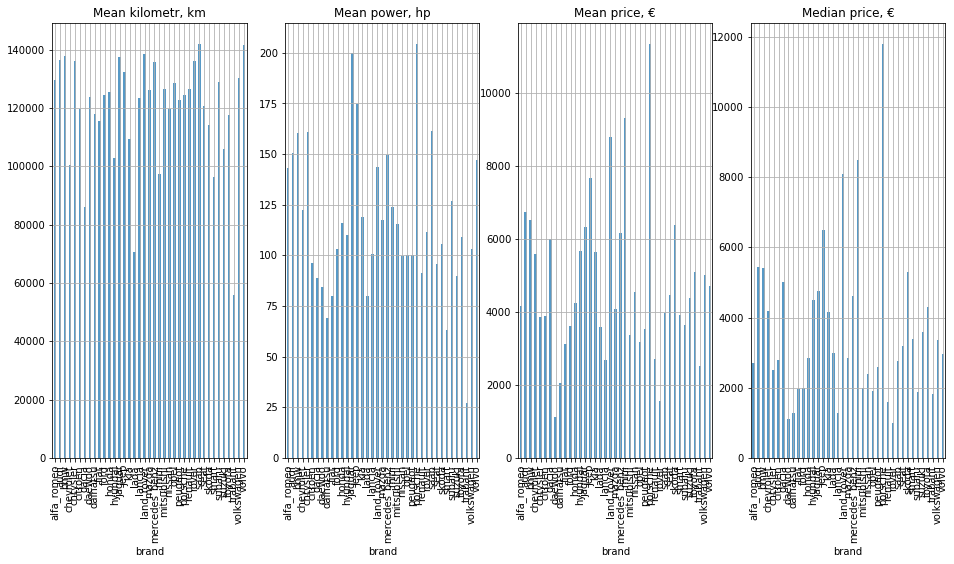

In [38]:
group_diagr(df, 'brand')

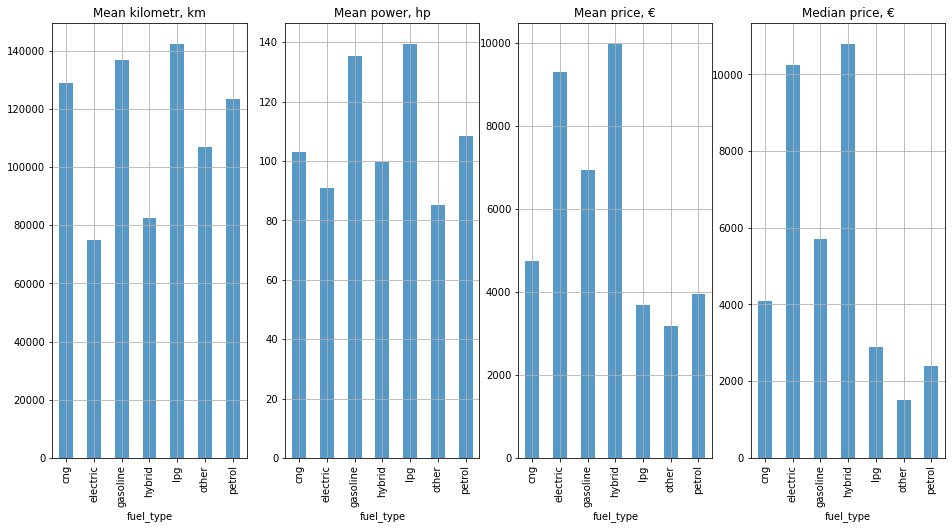

In [39]:
group_diagr(df, 'fuel_type')

Проверим число почтовых кодов 

In [40]:
df['postal_code'] = df['postal_code'].astype('object')
len(df['postal_code'].unique())

8077

Визуализировать такое количество почтовых кодов затруднительно, но вероятнее всего есть регионы с высоким доходом и следовательно стоимостью авто и низким. Данный столбец подвергнем таргет кодированию и позже попробуем посмотреть на корреляции его значимость.

#### Вывод:
При обработке данных были удалены лишние столбцы, заполнены пропуски, обработаны данные с учетом смысловой наполняющей - по итогу процент сохраненных данных 70.29%, что немного. Можно утверждать что данные были не готовы к исследованию.   
Столбцы `model`, `brand` и `postal_code` подвергнем таргет кодированию, чтобы не увеличивать массив данных. После проверим значимость с помощью корреляции. 

### Построение моделей <a id='model'></a>

Для построения модели воспользуемся таргет кодированием для столбцов `brand`, `postal_code` и `model`, а так же OHE кодированием для столбцов с несколькими значениями. Это позволит не увеличивать датасет и производить более быстрое обучение без потери признаков.

#### Проведем target кодирование

In [43]:
def price_code_brand (row):
    mean_pc = df.groupby('brand')['price'].mean()
    return mean_pc[row['brand']]

def price_code_model (row):
    mean_pc = df.groupby('model')['price'].mean()
    return mean_pc[row['model']]

def price_code_post (row):
    mean_pc = df.groupby('postal_code')['price'].mean()
    return mean_pc[row['postal_code']]

In [44]:
df['model_tar'] = df.apply(price_code_model, axis=1)    
df['brand_tar'] = df.apply(price_code_brand, axis=1)
df['postal_code_tar'] = df.apply(price_code_post, axis=1)
df.head(10)

price vehicle_type  registration_year gearbox  power    model  kilometer  \
0   9800          suv               2004    auto    163    grand     125000   
1   1500        small               2001  manual     75     golf     150000   
2   3600        small               2008  manual     69    fabia      90000   
3    650        sedan               1995  manual    102      3er     150000   
4   2200  convertible               2004  manual    109  2_reihe     150000   
5  14500          bus               2014  manual    125    c_max      30000   
6   2000        sedan               2004  manual    105  3_reihe     150000   
7   2799        wagon               2005  manual    140   passat     150000   
8    999        wagon               1995  manual    115   passat     150000   
9  17999          suv               2011  manual    190   navara      70000   

  fuel_type       brand not_repaired postal_code  sale_duration     model_tar  \
0  gasoline        jeep      no_data       90480             22   6563.082278   
1    petrol  volkswagen           no       91074              0   4693.215957   
2  gasoline       skoda           no       60437              6   4372.832083   
3    petrol         bmw          yes       33775              2   5309.266585   
4    petrol     peugeot           no       67112              4   3370.232400   
5    petrol        ford      no_data       94505              0   6476.483005   
6    petrol       mazda           no       96224             11   3420.032930   
7  gasoline  volkswagen          yes       57290              0   4931.127250   
8    petrol  volkswagen      no_data       37269             17   4931.127250   
9  gasoline      nissan           no        4177             16  10726.360000   

     brand_tar  postal_code_tar  
0  7664.738614      4855.000000  
1  5018.310671      5496.682927  
2  6384.857685      5601.174603  
3  6515.518600      4325.907895  
4  3524.420135      4917.333333  
5  3627.399875      6186.058824  
6  4085.619530      3752.055556  
7  5018.310671      4471.224719  
8  5018.310671      3744.795918  
9  4557.020420      3725.527778

Проверим итоговую корреляцию

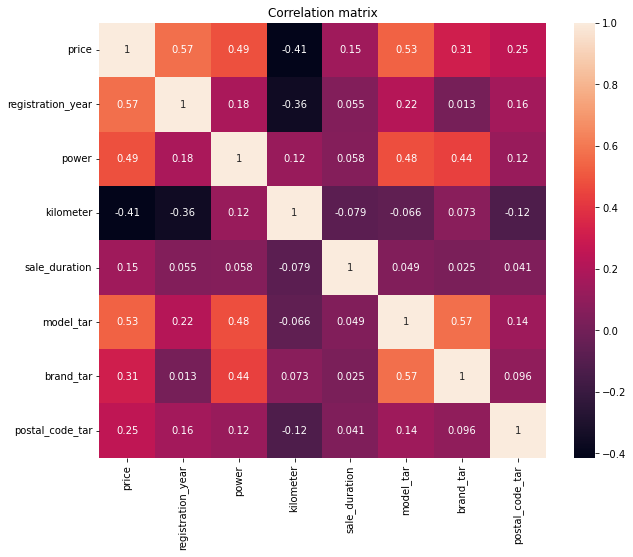

In [63]:
fig, axes = plt.subplots(1, 1, figsize=(10,8))
ax = sns.heatmap(df.corr(), annot=True)
ax.set_title('Correlation matrix')
plt.show()

#### Проведем OHE кодирование <a id='ohe'></a>

In [45]:
def get_dummies_func(data, column):
    ohe = pd.get_dummies(data[column], prefix=str(column), drop_first=True)
    data = data.drop(column, axis=1)
    return data.join(ohe)

In [46]:
prep_df = get_dummies_func(df, 'vehicle_type')
prep_df = get_dummies_func(prep_df, 'gearbox')
prep_df = get_dummies_func(prep_df, 'not_repaired')
prep_df = get_dummies_func(prep_df, 'fuel_type')

In [48]:
prep_df.drop(['model','brand','postal_code'], inplace=True, axis=1)

In [49]:
features = prep_df.drop(columns='price', axis=1)
target = prep_df['price']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123)


print('Train/test shapes:')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Train/test shapes:
(199275, 23) (49819, 23) (199275,) (49819,)


In [51]:
scaler = StandardScaler()
cols_for_scaler = [ 'model_tar', 'brand_tar', 'postal_code_tar', 'registration_year', 'sale_duration', 'power', 'kilometer']

scaler.fit(X_train[cols_for_scaler])

X_train[cols_for_scaler] = scaler.transform(X_train[cols_for_scaler])
X_test[cols_for_scaler] = scaler.transform(X_test[cols_for_scaler])

In [52]:
results = {}

#### LinearRegression <a id='lr'></a>

In [53]:
start = time.time() 
model = LinearRegression()
model.fit(X_train, y_train)
duration_learning = time.time() - start 

In [54]:
start = time.time()
prediction_lr = model.predict(X_test)
duration_prediction = time.time()-start
rmse = mean_squared_error(y_test, prediction_lr, squared=False).round(5)
print('R2: ',r2_score(y_test, prediction_lr).round(5))
print('RMSE for LR: ', rmse)

results['LinearRegression'] = [duration_learning, duration_prediction, rmse]

R2:  0.6791
RMSE for LR:  2566.90032


#### Ridge <a id='ridge'></a>

In [55]:
start=time.time()

parameters= {'alpha': range(0,20),
             'fit_intercept': [True, False],
             'copy_X': [True, False]}

grid_search = GridSearchCV(estimator = Ridge(), 
                           param_grid = parameters, 
                           cv = 5,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_mean_squared_error')
grid_search.fit(X_train, y_train)

duration_learning = time.time() - start 

In [56]:
print(grid_search.best_params_)
print('RMSE for valid Ridge: {:.2f}'.format((-grid_search.best_score_) ** 0.5))

{'alpha': 5, 'copy_X': True, 'fit_intercept': True}
RMSE for valid Ridge: 2586.46


In [57]:
start = time.time()
prediction_ridge = grid_search.best_estimator_.predict(X_test)

rmse = round((mean_squared_error(y_test, prediction_ridge, squared=False)), 2)

duration_prediction = time.time()-start
results['ridge'] = [duration_learning, duration_prediction, rmse]


print(f"RMSE for test Ridge: {rmse}")
print('R2: ',r2_score(y_test, prediction_ridge).round(5))

RMSE for test Ridge: 2566.82
R2:  0.67912


####  LightGBM <a id='lgbm'></a>

Выделим категориалильные признаки и числовые

In [58]:
num_features = cols_for_scaler
cat_features = [col for col in list(prep_df.columns) if col not in num_features]

In [59]:
train_data = lightgbm.Dataset(X_train, label=y_train, 
                              free_raw_data=False,
                              categorical_feature=cat_features)
test_data = lightgbm.Dataset(X_test, label=y_test)

param_grid = {'learning_rate': [0.05, 0.10, 0.20, 0.25, 0.30],
              'max_depth': [10, 11, 12, 13, 14],
             }


grid_search = GridSearchCV(estimator = lightgbm.LGBMRegressor(n_jobs = -1), 
                           param_grid = param_grid, 
                           cv = 5,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_mean_squared_error')

start = time.time()
grid_search.fit(X_train, y_train)
duration_learning = time.time() - start 

In [60]:
print(grid_search.best_params_)
print('RMSE for valid LightGBM: {:.2f}'.format((-grid_search.best_score_) ** 0.5))

{'learning_rate': 0.25, 'max_depth': 13}
RMSE for valid LightGBM: 1482.88


In [61]:
start = time.time()
preds_lgbm = grid_search.best_estimator_.predict(X_test)
rmse = round((mean_squared_error(y_test, preds_lgbm, squared=False)), 2)
duration_prediction = time.time()-start

print(f'RMSE for test LightGBM: {rmse}')
print('R2: ',r2_score(y_test, prediction_ridge).round(5))
results['lgbm'] = [duration_learning, duration_prediction, rmse]

RMSE for test LightGBM: 1490.99
R2:  0.67912


#### Вывод <a id='concl'></a>

В работе была проделана предообработка данных: 
1. Удалены лишние столбцы   
2. Добавлен столбец с информацией о предполагаемой длительности продажи  
3. Данные были очищены от пропусков и явных дубликатов  
4. Названия столбцов приведены в общепринятый вид  
5. Часть данных обработана с учетом смысловой наполняющей и доверительных интервалов.  

По окончанию предобработки данных осталось 70% от исходных данных, что говорит о неготовности данных к работе.  

Работа проведена с использованием моделей LinearRegression, Ridge и LGBM. Наилучший результат показала модель LGBM, однако у нее и самое большое время работы. Модели LR и Ridge показали одинаковый результат, несмотря на подбор параметров. Условиям задачи удовлетворяет только модель LGBM.

In [62]:
table = pd.DataFrame.from_dict(results)
index_names = ['Learning', 'Prediction', 'RMSE']
table['index'] = index_names
display(table.set_index('index'))

LinearRegression        ridge         lgbm
index                                                 
Learning            0.233183    23.885395    55.282423
Prediction          0.011010     0.013002     0.082536
RMSE             2566.900320  2566.820000  1490.990000